# The Hawaii Cesspool Hazard Assessment & Prioritization Tool:
# Molokai Version 3


## ................................................ Code Notebook ................................................
*September 2024*

**Prepared For:** 
NOAA Coastal Zone Management Progam

**Principal Investigator and Primary Software Developer** 
- Christopher Shuler Ph.D., Shuler Hydrologic LLC


### Highlights for Version 3
- Updated using existing methodology to include the island of Molokai
- Using a digital ocean space cloud storage bucket to reference large files for the code, so as not to keep them in the repo


### Methods: Input datasets

#### Physical drivers and risk factors
- These are factors that physically control the transport, attenuation, or otherwise affect the level of impact an OSDS at a given location will have on the environment and water quality

- Methodology for Molokai remained consistant with the 2021/2022 version for all datasets. Where congruent datasets did not exist before (groundwater flowpaths, ecosystem factors, etc...) we developed these datasets through the assistance of our partners and are highly appreciative of their assistance in bringing Molokai into the HCPT 
- The impact of an individual OSDS depends on an array of factors regarding the substrate within which it is installed, its location and proximity to sensitive areas, the ultimate discharge point of its effluent and the conservative constituents therein, and the cumulative impacts of other nearby OSDS, which together may more quickly overwhelm the adsorption and contaminant attenuation capacity of the subsurface than an individual system would. 
- We considered all numerically or categorically quantifiable factors relating to variability in OSDS impacts, for which we were able to find statewide datasets, we call these "Risk Factors". 
- While some of the risk factor datasets had missing values we generally only included datasets for which we had a minimum of 90% coverage of the OSDS in the state. 
- For each risk factor we defined a scaler relationship or score between the variable and the spatial location of every individual OSDS unit which was then weighted, and averaged with the scores of all other risk factors to produce a single final prioritization ranking 
- for each individual OSDS in our state-wide inventory, we calculated a numeric value based on the relationship between the location of the OSDS unit and the spatial distribution of the risk factor so that every OSDS unit is assigned a score for every risk factor. 


#### Value- based risk factors
While the physical factors control the level of impact, we have also included value-based factors that quantify the spatial distribution of human and environmental value within the areas calculated to be affected by the discharge of cesspool effluent through the use of groundwater flow modeling.

In [1]:
# load up dependencies and local functions
%run functions_v2.py
from IPython.display import Image

# relative paths   KEEPING THESE FOR A MINUTE IN CASE THE BELOW SCREWS THINGS UP
#homedir = os.getcwd()
#if not os.path.exists(os.path.join(homedir,'tempspace')): os.makedirs(os.path.join(homedir,'tempspace'))  
#tempspace = os.path.join(homedir, "tempspace")
#if not os.path.exists(os.path.join(".", 'Outputs/intermidiate_DataFrames')): os.makedirs(os.path.join(".", 'Outputs/intermidiate_DataFrames'))  
#intermidiate_DataFramesPath = os.path.join(".", 'Outputs/intermidiate_DataFrames')

homedir = os.getcwd()
tempspace = os.path.abspath(os.path.join(homedir, "tempspace"))
os.makedirs(tempspace, exist_ok=True)
intermidiate_DataFramesPath = os.path.abspath(os.path.join(".", "Outputs", "intermidiate_DataFrames"))
os.makedirs(intermidiate_DataFramesPath, exist_ok=True)

pd.set_option('display.max_rows', 10)

In [2]:
# To save time, load dataframes from the pre-run analysis
for i in os.listdir(intermidiate_DataFramesPath):
    name = i.split(".")[0]
    tempframe = pd.read_csv(os.path.join(intermidiate_DataFramesPath, i), index_col=0)
    globals()[str(name)] = tempframe   # This is sly, use globals to define an in-memory variable 
#osds_path = os.path.join(tempspace, "OSDS_cleaned.shp")

# This takes the directory of CSV files from intermidiate_DataFramesPath, if the code has been run yet) to dynamically
# load each CSV into a separate global variable, where the variable name is based on the CSV file's name.
# In essence, it's automatically loading each CSV into memory as a DataFrame and naming the variables after the CSV file names.

## Download large files >100mb from offsite repo 
note this has a long run time! 

- Some of the files this notebook depends on are too large to be hosted by GitHub (The DEM is 1.2 GB)
- One solution is to place these files into a cloud-based repositiry, in this case I use Digital Ocean spaces, and then just download them at the beginning of the work session
- Once the analysis is complete You can either use the cell at the bottom of the notebook to remove these files from your Github Repo so any updates dont include the large files OR the folder specified here is in the GITIGNORE file and will not be pushed back up to the repo. 

In [3]:
### Grab the Lidar elevation data: 
#LIDAR_file_urls = ['https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tfw', 
#            'https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tif.aux.xml',
#            'https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tif.xml', 
#            'https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tif.ovr', 
#            'https://hcpt-large-file-storage.sfo3.digitaloceanspaces.com/Lidar_DEM_molokai/Lidar_DEM/MoKaiLiDar.tif']

#LIDAR_local_folder = os.path.join("..", "Projected_data\\DEMs\\Lidar_DEM")

#download_files_from_public_endpoint(LIDAR_file_urls, LIDAR_local_folder) 

## Import OSDS File 
##### This creates a clean OSDS file from which all other cells will pull 
Currently using OSDS_v6 which incorporates 2020 updates from the DoH Wastewater branch (v3) IWS Database (V4) as well as the 4 counties tax records dwelling databases (V5).  This can easily be substituted as updates to the OSDS inventory are created.  This version wa run specifically for Molokai based on the Molokai V5 OSDS dataset made for Nancy at DHHL
This adds 1280 cesspools to the tool, thereby increasing the number of cesspools in the tool to 82141 + 1280   = 83421

In [3]:
# Read in latest OSDS dataset  has to have an X and Y column in WGS 84
fromshp = os.path.join(os.path.abspath("../Projected_data/OSDS_v7_Cleaned"), "CESSPOOLS_v7_Cleaned.shp")

OSDS = Format_OSDS_shp(fromshp, cleanitup=True)

# Deal with Dupes
checkdup = OSDS.pivot_table(index=['Uid'], aggfunc='size')
#print(f"there are duplicate points at: {checkdup[checkdup != 1]}")
# remove the duplicates (keep first entry of the duplicate row)
OSDS.drop_duplicates(subset=['Uid'], keep="first", inplace=True)
# Reindex or else the future joins will be based on an index with dupes
OSDS.reset_index(drop=True, inplace=True)

# Save csv
OSDS.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS.csv"))

# Convert the now formatted OSDS csv back to a shapefile for the subsequent analyses
csvFilePath = os.path.join(intermidiate_DataFramesPath, "OSDS.csv")
convert_OSDS_csv_to_shp(csvFilePath)

# Define the cleaned up OSDS file all the other cells can use
osds_path = os.path.join(tempspace, "OSDS_cleaned.shp")
print("There are {} (OSDS or Cesspools) in this dataset".format(len(OSDS)))

There are 1280 (OSDS or Cesspools) in this dataset


## Distance to Municipal or domestic wells 

Refs: Whittier 2010 Groundwater source assessment program for the state of Hawaii, USA: methodology and example application Robert B. Whittier & Kolja Rotzoll & Sushant Dhal & Aly I. El-Kadi & Chittaranjan Ray & Daniel Chang

Mair, A., & El-Kadi, A. I. (2013). Logistic regression modeling to assess groundwater vulnerability to contamination in Hawaii, USA. Journal of contaminant hydrology, 153, 1-23.

Average dist2_MunWells_m is 6136.686624233692
Max dist2_MunWells_m is 27573.791625909995
Min dist2_MunWells_m is 109.2669483779694


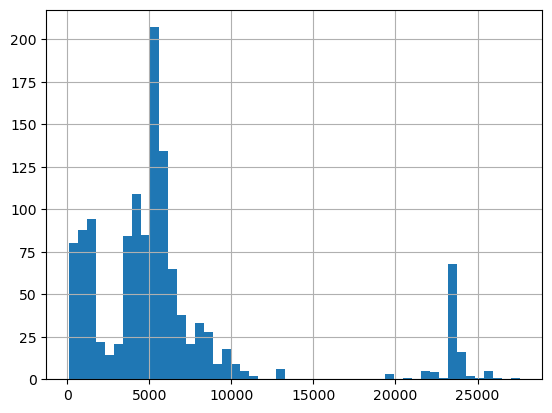

In [5]:
# Generate parameter info about the Municipal wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Wells", 'CWRM_Wells_MUN_prj.shp')
new_col_name = "dist2_MunWells_m"
# Run the near analysis 
MUN_WELLS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
MUN_WELLS.to_csv(os.path.join(intermidiate_DataFramesPath, "MUN_WELLS.csv"))
# plot histogram
Hist_and_stats_on_DF(MUN_WELLS, "dist2_MunWells_m")

Average dist2_DomWells_m is 11131.886130709723
Max dist2_DomWells_m is 36562.9600721132
Min dist2_DomWells_m is 32.43253763593678


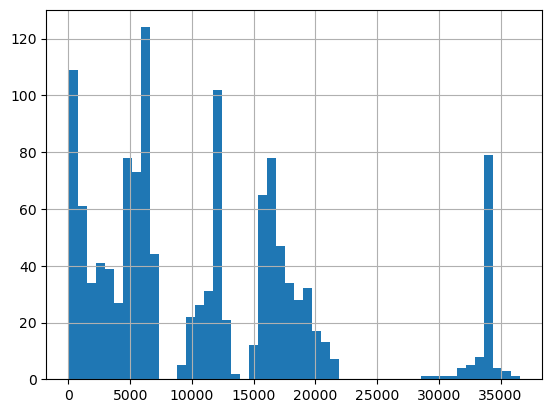

In [6]:
# Generate paramater info about the Domestic wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Wells", 'CWRM_Wells_DOM_prj.shp')
new_col_name = "dist2_DomWells_m"
# Run the near analysis 
DOM_WELLS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
DOM_WELLS.to_csv(os.path.join(intermidiate_DataFramesPath, "DOM_WELLS.csv"))
# plot histogram
Hist_and_stats_on_DF(DOM_WELLS, "dist2_DomWells_m")

## Well capture zones

While the distance from the well as related to the zone threshold was directly assessed we also did an analysis of which osds were located in municipal well capture zones provided by the HI department of health. The composite capture zone dataset as it is publically available and presented in the references below was provided upon request by Bob Whittier at Hi-DOH.

#### Inside Well capture Zone B

In [7]:
In_polygons = os.path.join("..", "Projected_data/Well_CZs", 'ZoneB_Composite_Molokai.shp')
new_col_name = 'In_WellCZ_B'
In_points = osds_path

WellCZ_B_yes = Find_points_inside_polys(In_points, In_polygons, new_col_name)
WellCZ_B_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "WellCZ_B_yes.csv"))

print_stats_on_bool_layers(WellCZ_B_yes)

number of affected points = 3
number of total systems = 1280
percent of systems affected = 0.00234375


#### Inside Well capture Zone C

In [8]:
In_polygons = os.path.join("..", "Projected_data/Well_CZs", 'ZoneC_Composite_Molokai.shp')
new_col_name = 'In_WellCZ_C'
In_points = osds_path

WellCZ_C_yes = Find_points_inside_polys(In_points, In_polygons, new_col_name)
WellCZ_C_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "WellCZ_C_yes.csv"))

print_stats_on_bool_layers(WellCZ_C_yes)

number of affected points = 36
number of total systems = 1280
percent of systems affected = 0.028125


## Distance to streams

Streams layer from Hawaii GIS online is representative of perennial and perennial and non-perennial flowing waters in the state as of 2008. This layer is sometimes referred to as "DAR Streams." Source: USGS Digital Line Graphs, 1983 version; CWRM Hawaii Stream Assessment database, 1993; DLNR Division of Aquatic Resources, 2004, 2008, 2013. (Note - 2013 update from CWRM and DAR included attribute corrections and addition of tributary names, data is current as of March, 2008).

Average dist2_Streams_m is 269.1439032010702
Max dist2_Streams_m is 1148.2034885279843
Min dist2_Streams_m is 0.17522737621947


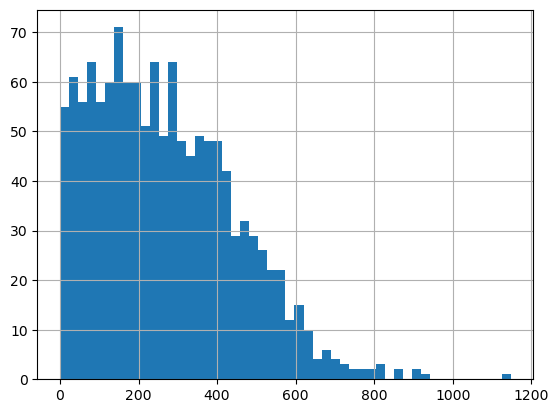

In [9]:
# Generate parameter info about the Municipal wells MODERATE RUN TIME
shp_path = os.path.join("..", "Projected_data/Streams", 'Streams_prj.shp')
new_col_name = "dist2_Streams_m"
# Run the near analysis 
STREAMS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
STREAMS.to_csv(os.path.join(intermidiate_DataFramesPath, "STREAMS.csv"))
# plot histogram
Hist_and_stats_on_DF(STREAMS, "dist2_Streams_m")

## Distance to Wetlands

Using a basic geographic distance calculation to the nearest point on the streams shapefile from: HAWAII GIS:(https://geoportal.hawaii.gov/datasets/2250370303ef44c8becf4fbe549e3f43_39, https://www.arcgis.com/sharing/rest/content/items/2250370303ef44c8becf4fbe549e3f43/info/metadata/metadata.xml?format=default&output=html)

Average dist2_Wetlands_m is 1665.5795881189017
Max dist2_Wetlands_m is 8630.798943379401
Min dist2_Wetlands_m is 11.248930450716015


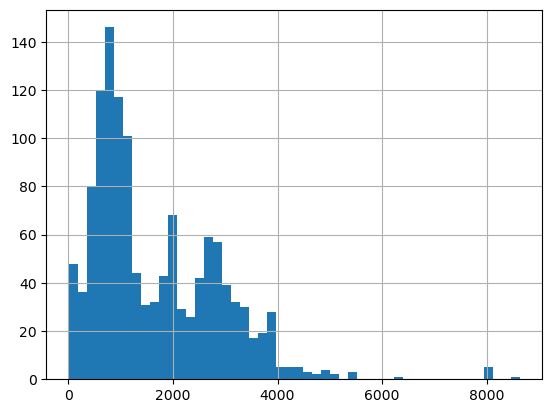

In [10]:
# Generate parameter info about the wetlands
shp_path = os.path.join("..", "Projected_data/Wetlands", 'Wetlands_emergent_ponds.shp')
new_col_name = "dist2_Wetlands_m"
# Run the near analysis 
WETLANDS = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
WETLANDS.to_csv(os.path.join(intermidiate_DataFramesPath, "WETLANDS.csv"))
# plot histogram
Hist_and_stats_on_DF(WETLANDS, "dist2_Wetlands_m")

## Distance to the coastline

Here we are using a basic geographic distance calculation to the nearest point on the Hawaii coastline shapefile taken from Hawaii GIS online. (https://geoportal.hawaii.gov/datasets/045b1d5147634e2380566668e04094c6_3/explore?location=20.556650%2C-157.478000%2C8.60, https://geodata.hawaii.gov/arcgis/rest/services/Terrestrial/MapServer/3)

Average dist2_coast_m is 1015.4060271804603
Max dist2_coast_m is 5113.37133490945
Min dist2_coast_m is 2.692405061916618


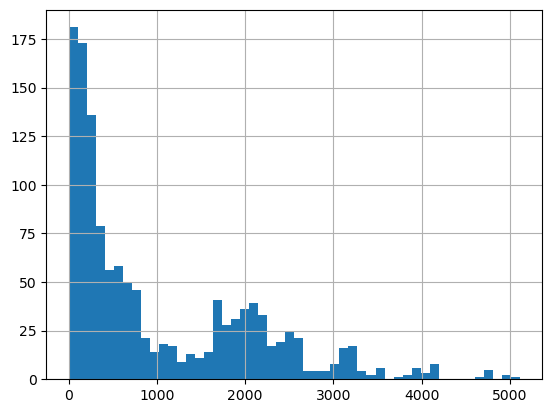

In [11]:
# Generate parameter info about the COASTLINE   looong RUN TIME 
shp_path = os.path.join("..", "Projected_data/Coastline", 'Coastline_line_prj.shp')
new_col_name = "dist2_coast_m"
# Run the near analysis 
COASTLINE = Calc_dist_to_variable(osds_path, shp_path, new_col_name)
COASTLINE.to_csv(os.path.join(intermidiate_DataFramesPath, "COASTLINE.csv"))
# plot histogram
Hist_and_stats_on_DF(COASTLINE, "dist2_coast_m")

## Extracting values from Rainfall raster 
(note need to run this cell before running soils block below) 

- Rainfall directly affects the contamination potential of an OSDS by way of being a proxy for groundwater recharge, whereas:
- a moderate amount of OSDS leachate can significantly increase the groundwater nitrate concentration in low groundwater recharge areas such as the west Hawaii Island.  By contrast, it will take a much greater amount of OSDS leachate to result in even a moderate increase in the groundwater nitrate concentration in high recharge area such as the east side of Hawaii island. 


##### Using rainfall data to fill missing soil flooding values
Addiitionally, rainfall can also act as a proxy for flooding potential, which can cause surface transport of contamination from OSDS, especially cesspools, and cause public health risks. The flood frequency of many locations is already defined by the NRCS soils database, though about fifty (50) percent of the cesspool points were missing flood-frequency data from the NRCS database. Therefore, rainfall amounts were used to determine the likelihood of flooding only in those areas where it was not defined by the NRCS database using the following logic. This logic was established through consultation with DOHWWB and engineering professionals 

- If rainfall is above 135 in and ksat is < 1.1 = Frequent Flooding
- If rainfall is below 15 in and ksat is < 1.1 = Frequent Flooding
- If rainfall is above 135 or ksat is below ksat < 1.1 = Occasional Flooding
- The rainfall data itself was pulled from the Hawai‘i climate atlas as statewide grids of annual rainfall totals. 
(http://rainfall.geography.hawaii.edu/)

To associate the rainfall amounts we extracted the annual rainfall value (in inches) from the rainfall raster to each OSDS point

Average rainfall_in is 27.453143500624996
Max rainfall_in is 101.3880005
Min rainfall_in is 9.6635904


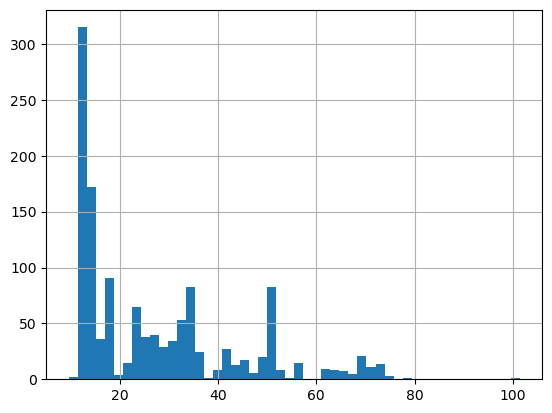

In [12]:
In_raster = os.path.join("..", "Projected_data/Rain", 'Rain_inann.tif')
In_points = osds_path
new_col_name = "rainfall_in"

RAINFALL = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)
RAINFALL.to_csv(os.path.join(intermidiate_DataFramesPath, "RAINFALL.csv"))
# plot histogram
Hist_and_stats_on_DF(RAINFALL, "rainfall_in")

## Soils 

- These data were extracted data straight from the NRCS database(https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/geo/?cid=nrcs142p2_053627) , (Ksat data is much better resolution than with the Hawaii soil atlas, which we also looked at https://gis.ctahr.hawaii.edu/SoilAtlas). 


- As noted above: FloodFrequency variable was missing in about half of features so it is filled in with combination of rainfall and k-sat below. 


- Because soil data is polygon data we simply assigned each OSDS point the value of the soil parameter of interest. 
- Parameters included: 
  - **Flood Frequency** - Degree to which the soil is subject to flooding or ponding (nrcs_FloodFreq)
  - **Depth to bedrock** or cemented pan (nrcs_DtoBrock)
  - **Filtering characteristics of the soil** (nrcs_ksat_rep) with ksat >12 ft/day being poor filtering capacity
  - **Rate of water infiltration** through the soil (nrcs_ksat_rep) with ksat < 1.2 ft/day being poor infiltration capacity 
  - **Rate of seepage** out of the bottom layer of the soil (nrcs_ksat_rep) with ksat < 1.1 ft/day being poor seepage
  - **Topographic slope** with slope of more than 15% being problematic for OSDS installation and conversions 
  - **Fraction of rock fragments** in the soil with a % of 3-in rock fragments more than 50% being problematic. 
  - Note that meaning can derived from thresholds in the table in Whittier and El-Kadi (2014) on pg 7-4 (see that table exact limitation numbers) https://health.hawaii.gov/wastewater/files/2015/09/OSDS_NI.pdf
  
  
- These parameters followed the methodology and weighting scheme of Whittier and El-Kadi (2014) (pg 7-4) to create a single soil suitability ranking


- note that the NRCS septic suitability rank was of little value (it was all bad) which is also noted in Whittier and El-Kadi (2014)

In [13]:
# Pull in soils data from NRCS
In_polygons = os.path.join("..", "Projected_data/Soils", 'HIstate_nrcs_join2.shp')
new_col_name = 'Soil_Ksat_2ndry'
In_points = osds_path

# Columns you want from the shapefile (Uid should always  be first one) 
want_cols = ['Uid', 'brockdepmin', 'flodfreqdcd', 'engstafdcd', 'engstafll', 
             'engstafml', 'cokey', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_r', ]  # 'totalsub_r', slopegradw

renames = {'brockdepmi':'nrcs_DtoBrock', 
 'flodfreqdc':'nrcs_FloodFreq',
 'engstafdcd':'nrcs_septic_dominant', 
 'engstafll':'nrcs_septic_least', 
 'engstafml':'nrcs_septic_most', 
 'ksat_h':'nrcs_ksat_hi',  
 'ksat_l':'nrcs_ksat_lo',
 'ksat_r':'nrcs_ksat_rep', 
 'sieveno10_':'nrcs_rockFrag3in'}    # 'slopegradw':'nrcs_slope', 'totalsub_r':'nrcs_subsidence'

# Do the spatial join
arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(tempspace, "test_join_pt_2_poly.shp"))

# read data from shapefile 
extracted_points_path = os.path.join(tempspace, "test_join_pt_2_poly.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))

want_cols = ['Uid', 'brockdepmi', 'flodfreqdc', 'engstafdcd', 'engstafll', 
             'engstafml', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_'] # 'slopegradw' , 'totalsub_r'
Extract_frame = Extracted_All[want_cols]

Extract_frame = Extract_frame.replace('NoData', np.nan)  # clean up from arc's trashiness

numcols = ['brockdepmi', 'ksat_h', 'ksat_l', 'ksat_r', 'sieveno10_' ]  #'slopegradw',  'totalsub_r'
Extract_frame[numcols] = Extract_frame[numcols].apply(pd.to_numeric, errors='coerce', axis=1)

Extract_frame.rename(columns=renames, inplace=True)     # Rename to col that you want

SOILS_NRCS = Extract_frame.copy()


#### Filling in missing NRCS flood frequency data with rainfall and ksat
SOILS_NRCS = SOILS_NRCS.merge(RAINFALL, on="Uid", how='left')

# Set frequents 
SOILS_NRCS.loc[(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1) & (SOILS_NRCS['rainfall_in'] > 135), 'nrcs_FloodFreq'] = "Frequent"
SOILS_NRCS.loc[(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1) & (SOILS_NRCS['rainfall_in'] < 15), 'nrcs_FloodFreq'] = "Frequent"


# Set Occasionals 
SOILS_NRCS.loc[(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['rainfall_in'] > 135), 'nrcs_FloodFreq'] = "Occasional"
SOILS_NRCS.loc[(SOILS_NRCS['nrcs_FloodFreq'].isnull()) & (SOILS_NRCS['nrcs_ksat_rep'] < 1.1), 'nrcs_FloodFreq'] = "Occasional"

# set rest to none
SOILS_NRCS.loc[SOILS_NRCS['nrcs_FloodFreq'].isnull(), 'nrcs_FloodFreq'] = "None"

del SOILS_NRCS['rainfall_in']

SOILS_NRCS.to_csv(os.path.join(intermidiate_DataFramesPath, "SOILS_NRCS.csv"))

## Slope
Data is derived from statewide 10 m DEMs from the Geology coastal group page (http://www.soest.hawaii.edu/coasts/data/hawaii/dem.html) 

Average slope_deg is 3.8724777515294124
Max slope_deg is 45.6594009
Min slope_deg is 0.0


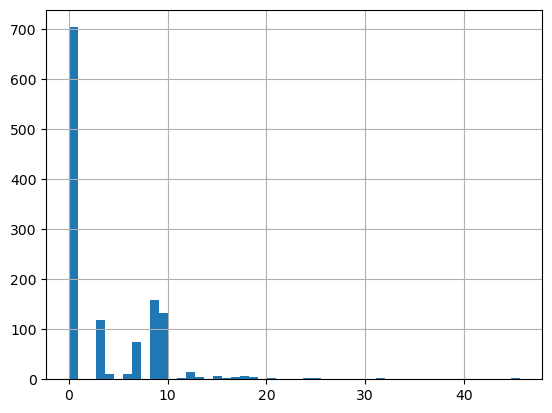

In [14]:
blankframe = pd.DataFrame(columns=["Uid"])

indir = os.path.join("..", "Projected_data\\DEMs\\Slope_WGS")  # Using a loop to go over different rasters from different islands
for idx, file in enumerate(os.listdir(indir)):
    if file.endswith(".tif"):
        In_raster = os.path.join(indir, file)
        In_points = osds_path
        new_col_name = "slope_{}".format(idx)       
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['slope_deg'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

SLOPE = blankframe[["Uid", 'slope_deg']]
SLOPE.to_csv(os.path.join(intermidiate_DataFramesPath, "SLOPE.csv"))
# plot histogram
Hist_and_stats_on_DF(SLOPE, "slope_deg")

## Depth to water 
#### Water table Elevations
Did a bit of processing (in tif format in WGS 84) from Bob Whittier's models (obtained through personal communication) 

- The unsaturated zone underlying a cesspool or leachfield is the primary site of subsurface treatment and contaminant attenuation, and the thickness of the unsaturated zone below an OSDS is a major factor in the ability of a given OSDS to treat wastewater.  
- To obtain an estimate of depth to water I first needed to extract ESTIMATED/modeled WT elevations from Bob's groundwater models.  The best citations for these models are:  
 
 
- Whittier, R.B., and El-Kadi, A. I. (2009). Human and environmental risk ranking of onsite sewage disposal systems. Retrieved from: https://health.hawaii.gov/wastewater/files/2015/09/OSDS_OAHU.pdf
- Whittier, R.B., and El-Kadi, A. I. (2014). Human health and environmental risk ranking of onsite sewage disposal systems for the Hawaiian Islands of Kaua'i, Moloka'i, Maui, and Hawai'i. Retrieved from https://health.hawaii.gov/wastewater/files/2015/09/OSDS_NI.pdf
 
 
- Water table depth was calculated in combination with land surface elevation. 
- Unfortunately There is no statewide high-resolution (<1 m dem) lidar data for the state, only for the coastlines. Therefore I downloaded the coastline lidar data from HI GIS online (https://www.arcgis.com/home/webmap/viewer.html?url=https%3A%2F%2Fgeodata.hawaii.gov%2Farcgis%2Frest%2Fservices%2FSoH_Imagery%2FHawaii_DSM%2FImageServer&source=sd) and extracted elevation data to each OSDS point that intersected the available data. 
- Then I filled in missing elevation values with a lower resolution data set (10 m DEMS)  from the UH Coastal Geology group (http://www.soest.hawaii.edu/coasts/data/hawaii/dem.html) 
 
- With the best possible land surface elevation data, and the modeled water table elevations, we subtracted the land elevation from the water table elevation to derive the estimated depth to water. 
- While this is a modeled estimate it is the best available data for a notoriously uncertain parameter.

##### Justification for threshold used:  
From Whittier 2014 pg 4-2 
In this study, the minimum depth to groundwater that allows for sufficient pathogen removal was based on the OSDS design regulations for cesspools. HAR Title 11, Chapter 62 establishes the regulations for wastewater systems and requires that:
• the top of a cesspool inlet pipe must be 1.5 ft below grade;
• there is a minimum of 10 ft between the inlet pipe and the bottom of the tank; and
• a minimum of 3 ft from the bottom of the tank and the highest known level of groundwater.
Based on these values, a minimum depth to the water table should be approximately 15 ft. However, the analysis can be uncertain due to the fact that the elevation of the water table is not static;

Average WT_elev_m is 1.8271601265145554
Max WT_elev_m is 85.998703
Min WT_elev_m is -0.539621


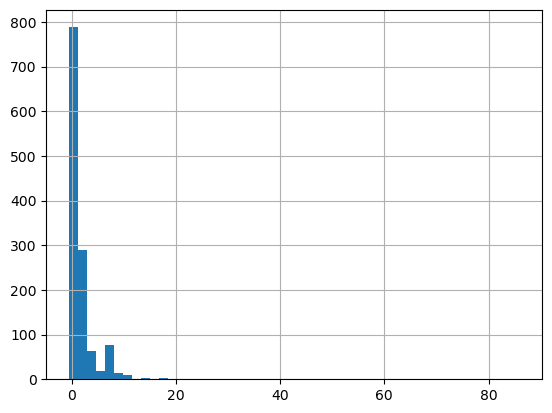

In [15]:
blankframe = pd.DataFrame(columns=["Uid"])
indir = os.path.join("..", "Projected_data\\Water_table\\Tiffs")

for idx, file in enumerate(os.listdir(indir)):     # Using a loop to go over different rasters from different islands
    if file.endswith(".tif"):
        In_raster = os.path.join(indir, file)
        In_points = osds_path
        new_col_name = "WT_elev_m_{}".format(idx)
         
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)   
        # Merge the different islands together 
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['WT_elev_m'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

WT_ELEV = blankframe[["Uid", 'WT_elev_m']]
WT_ELEV.to_csv(os.path.join(intermidiate_DataFramesPath, "WT_ELEV.csv"))
# plot histogram
Hist_and_stats_on_DF(WT_ELEV, "WT_elev_m")

### Land Surface elevations
This relies on first getting data from lidar dem (1m resolution), then if no data get data from the course (10m) resolution ones to create cohesive dataset

- Worst data downloading experience ever was the lame 10m dem  
- https://pae-paha.pacioos.hawaii.edu/erddap/griddap/usgs_dem_10m_molokai.html

##### Very long run time

working on MokaiWGS.tif
Average Elevation_m is 108.79574246026647
Max Elevation_m is 489.0899963
Min Elevation_m is 0.949632


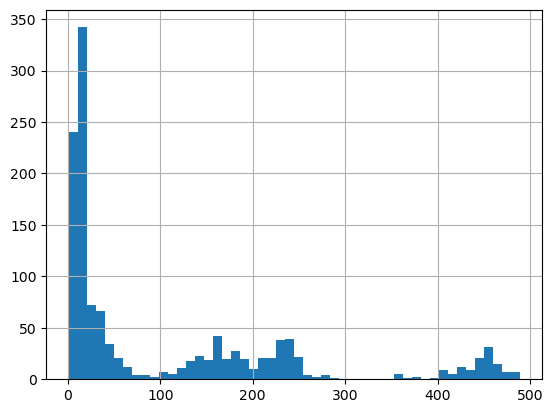

In [16]:
blankframe = pd.DataFrame(columns=["Uid"])
indir_crap = os.path.join("..", "Projected_data\\DEMs\\10mDEM_WGS")

for idx, file in enumerate(os.listdir(indir_crap)):   # Using a loop to go over different rasters from different islands
    if file.endswith(".tif"):
        print("working on {}".format(file))
        In_raster = os.path.join(indir_crap, file)
        In_points = osds_path
        # Define new collumn name you want
        new_col_name = "CrapElev_m_{}".format(idx)
        
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)   
        # Merge the different islands together 
        blankframe = blankframe.merge(foo, how='outer', on='Uid')
        
blankframe.set_index("Uid", inplace=True)
blankframe['CrapElev'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

ELEV_crap = blankframe[["Uid", 'CrapElev']]


####  Now do the same for the lidar dataset  to stitch on ####
blankframe = pd.DataFrame(columns=["Uid"])
indir_good = os.path.join("..", "Projected_data\\DEMs\\Lidar_DEM")

for idx, file in enumerate(os.listdir(indir_good)):   # Using a loop to go over different rasters from different islands
    if file.endswith(".tif"):
        print("working on {}".format(file))
        In_raster = os.path.join(indir_good, file)
        In_points = osds_path
        # Define new collumn name you want
        new_col_name = "LidarElev_m"
        
        foo = extract_values_from_rasters(In_raster, In_points, new_col_name, tempspace)   
        # Merge the different islands together 
        blankframe = blankframe.merge(foo, how='outer', on='Uid')

blankframe.set_index("Uid", inplace=True)
blankframe['LidarElev'] = blankframe.max(axis=1)  
blankframe.reset_index(inplace=True)

ELEV_good = blankframe[["Uid", 'LidarElev']]

# Now Merge Elevations to create a master elevation
Master = OSDS.copy()

Master = Master.merge(ELEV_good, on="Uid", how="left")
Master = Master.merge(ELEV_crap, on="Uid", how="left")

Master['Elevation_m'] = Master['LidarElev']

Master['Elevation_m'] = np.where((Master['LidarElev'].isnull()),   #Identifies the case to apply to 
                           Master['CrapElev'],      #This is the value that is inserted
                           Master['Elevation_m'])      #This is the column that is affected

ELEVATION = Master[["Uid", 'Elevation_m']]
ELEVATION.to_csv(os.path.join(intermidiate_DataFramesPath, "ELEVATION.csv"))

Hist_and_stats_on_DF(ELEVATION, "Elevation_m")

### Calculate Depth to Water for all OSDS points

C:\Users\CS\AppData\Local\Temp\ipykernel_25588\2210228354.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  DtoWater['Dep_to_Water_m'][DtoWater['Dep_to_Water_m'] < 0] = 0.999        # Where it is negative assign value of .999


Average Dep_to_Water_m is 107.64952725118297
Max Dep_to_Water_m is 481.5902061
Min Dep_to_Water_m is 0.999


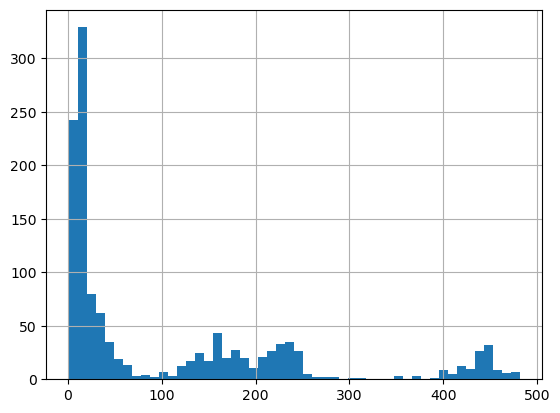

In [17]:
DtoWater = WT_ELEV.merge(ELEVATION, on="Uid", how='outer')                     # merge elevation and WT elevation
DtoWater['Dep_to_Water_m'] = DtoWater['Elevation_m'] - DtoWater['WT_elev_m']   # find the difference 

DtoWater['Dep_to_Water_m'][DtoWater['Dep_to_Water_m'] < 0] = 0.999        # Where it is negative assign value of .999

DTOWATER = DtoWater.copy()
DTOWATER.to_csv(os.path.join(intermidiate_DataFramesPath, "DTOWATER.csv"))

Hist_and_stats_on_DF(DTOWATER, "Dep_to_Water_m")

# Combination, horizontal + Vertical SLR effects
- This is a combination metric, composed of systems that EITHER are inside of the lateral 2d SLR zones as described by the scenarios below OR have a depth to groundwater value that becomes less than 4.4 m (the regulatory standard via 11-62) with a given increase in sea level (assuming purely linear hydrodynamic buoyancy of the freshwater lens under an increase in Base Sea Level) that matches the increase in Sea Level elevation for the future-scenario year.  

## Check if inside SLR zone 2030

Sea level rise data was collected from the HI GIS online https://geoportal.hawaii.gov/datasets/5a4e4fdac72e40bd846c8f3257afd4aa_59?geometry=-163.283%2C20.530%2C-152.829%2C22.320

- OSDS units are assigned highest priority rank if located within 2030 zone with descending ranks if located in 2050 to 2100. 

In [18]:
# Compile systems affected by Vertical SLR inundation
Vertical_SLR_2030 = DTOWATER[DTOWATER['Dep_to_Water_m'] < 4.9]
print("vertical stats"); print_stats_on_bool_layers(Vertical_SLR_2030)

# Compile systems in the horizontal surface flood zone
In_polygons = os.path.join("..", "Projected_data/SLR", 'slr_exposure_area_0_pt_5_ft.shp')
new_col_name = 'InSLR2030'
In_points = osds_path
Hor_SLR_2030 = Find_points_inside_polys(In_points, In_polygons, new_col_name)
print("Hor stats"); print_stats_on_bool_layers(Hor_SLR_2030)

SLR_2030_yes = Vertical_SLR_2030.merge(Hor_SLR_2030, on="Uid", how="outer")
SLR_2030_yes = SLR_2030_yes[['Uid', new_col_name]]
SLR_2030_yes[new_col_name] = True   # be sure to set all the rows that are in hor or vert zone to true

SLR_2030_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "SLR_2030_yes.csv"))
print("Vert+Hor stats"); print_stats_on_bool_layers(SLR_2030_yes)

vertical stats
number of affected points = 10
number of total systems = 1280
percent of systems affected = 0.0078125
Hor stats
number of affected points = 1
number of total systems = 1280
percent of systems affected = 0.00078125
Vert+Hor stats
number of affected points = 11
number of total systems = 1280
percent of systems affected = 0.00859375


### Check if inside SLR zone 2050 


In [19]:
# Compile systems affected by Vertical SLR inundation
Vertical_SLR_2050 = DTOWATER[DTOWATER['Dep_to_Water_m'] < 5.5]
print("vertical stats"); print_stats_on_bool_layers(Vertical_SLR_2050)

# Compile systems in the horizontal surface flood zone
In_polygons = os.path.join("..", "Projected_data/SLR", 'slr_exposure_area_1_pt_1_ft.shp')
new_col_name = 'InSLR2050'
In_points = osds_path
Hor_SLR_2050 = Find_points_inside_polys(In_points, In_polygons, new_col_name)
print("Hor stats"); print_stats_on_bool_layers(Hor_SLR_2050)

SLR_2050_yes = Vertical_SLR_2050.merge(Hor_SLR_2050, on="Uid", how="outer")
SLR_2050_yes = SLR_2050_yes[['Uid', new_col_name]]
SLR_2050_yes[new_col_name] = True  # be sure to set all the rows that are in hor or vert zone to true

SLR_2050_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "SLR_2050_yes.csv"))
print("Vert+Hor stats"); print_stats_on_bool_layers(SLR_2050_yes)

vertical stats
number of affected points = 18
number of total systems = 1280
percent of systems affected = 0.0140625
Hor stats
number of affected points = 3
number of total systems = 1280
percent of systems affected = 0.00234375
Vert+Hor stats
number of affected points = 21
number of total systems = 1280
percent of systems affected = 0.01640625


### Check if inside SLR zone 2100

In [20]:
# Compile systems affected by Vertical SLR inundation
Vertical_SLR_2100 = DTOWATER[DTOWATER['Dep_to_Water_m'] < 7.6]
print("vertical stats"); print_stats_on_bool_layers(Vertical_SLR_2100)


In_polygons = os.path.join("..", "Projected_data/SLR", 'slr_exposure_area_3_pt_2_ft.shp')
new_col_name = 'InSLR2100'
In_points = osds_path
Hor_SLR_2100 = Find_points_inside_polys(In_points, In_polygons, new_col_name)
print("Hor stats"); print_stats_on_bool_layers(Hor_SLR_2100)

SLR_2100_yes = Vertical_SLR_2100.merge(Hor_SLR_2100, on="Uid", how="outer")
SLR_2100_yes = SLR_2100_yes[['Uid', new_col_name]]
SLR_2100_yes[new_col_name] = True    # be sure to set all the rows that are in hor or vert zone to true

SLR_2100_yes.to_csv(os.path.join(intermidiate_DataFramesPath, "SLR_2100_yes.csv"))
print("Vert+Hor stats"); print_stats_on_bool_layers(SLR_2100_yes)

vertical stats
number of affected points = 125
number of total systems = 1280
percent of systems affected = 0.09765625
Hor stats
number of affected points = 75
number of total systems = 1280
percent of systems affected = 0.05859375
Vert+Hor stats
number of affected points = 186
number of total systems = 1280
percent of systems affected = 0.1453125


## Calculate OSDS Density 

Careful parameterization is needed for this, as it can greatly affect the results. 
key questions are how far away from another OSDS does an OSDS need to be for their effects across the landscape to not be cumulative?  This is represented by the parameter:

-  effect_distance

We set this at 360m because personal communication with Joquim at WAI saying that most properties in Hawaii are 1 acre (which is incorrect). Therefore the base resolution of this density analysis is number of OSDS per acre, looking at a 1 acre cell size with a 10 acre search distance around each OSDS

A cell size of 64 meters creates 1 acre cells

- Then the threshold for prioritization was set at one units per 10000 sqft, apparently a thresholds in 11-62?
- This translates to a per acre density of 4.23 units per acre. Note that this was adjusted to 1/4 of this value 1.089 because we are preferring to use a threshold of number of units per acre as it makes more sense in this geography, regarding the note above. 

Average OSDS_Density_perAcre is 0.34779322031249993
Max OSDS_Density_perAcre is 1.56609
Min OSDS_Density_perAcre is 0.0099119


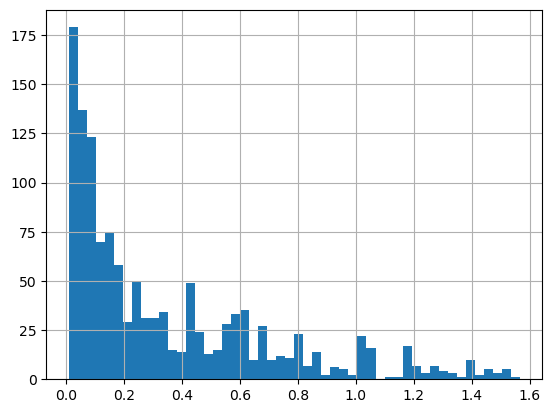

In [21]:
# Project the OSDS dots into UTM4n to get units of meters
input_features = os.path.join(os.path.abspath("../Projected_data/OSDS_v7_Cleaned"), "CESSPOOLS_v7_Cleaned.shp")
OSDS_utm_path = os.path.join(tempspace, "ClassIV_cespool_UTM4N.shp" )  # replacing "..", "Projected_data/OSDS/UTM", "ClassIV_cespool_UTM4N.shp"
out_coordinate_system = arcpy.SpatialReference('WGS 1984 UTM Zone  4N')
arcpy.Project_management(input_features, OSDS_utm_path, out_coordinate_system)

# Density Parameters
effect_distance_m = 360.5
Density_units = "ACRES"
cellSize = 64     
new_col_name = "OSDS_Density_perAcre"   # Define new collumn name you want

# internal parameters
myNbrCirc = NbrCircle(effect_distance_m, "MAP")
populationField = "NONE"
# Run density algo
outPdens = PointDensity(OSDS_utm_path, populationField, cellSize, myNbrCirc, Density_units)
outPdens.save(os.path.join(tempspace, 'CessPool_density.tif'))

# Convert format to dataframe
In_raster = outPdens
In_points = osds_path
ExtractValuesToPoints(In_points, In_raster, os.path.join(tempspace, "test_rain_OSDS.shp"))

# read on OSDS data from shapefile into dataframe 
extracted_points_path = os.path.join(tempspace, "test_rain_OSDS.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))


#Select only selected columns
want_cols = ['Uid', 'RASTERVALU']
Extract_frame = Extracted_All[want_cols]
Extract_frame.rename(columns={'RASTERVALU':new_col_name}, inplace=True)     # Rename to col that you want
Extract_frame.loc[Extract_frame[new_col_name] < 0] = np.nan                 # Deal with the -9999 values set to nan

OSDS_DENSITY = Extract_frame.copy()
OSDS_DENSITY.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS_DENSITY.csv"))

Hist_and_stats_on_DF(OSDS_DENSITY, "OSDS_Density_perAcre")

## Import the Coastal Endpoint ID's from the Bob Model flowpaths

Here referred to as 'Flikr_ID' these are just the 250 m points/cells all along the coastline for all islands with a unique ID that can be used to assign an inland unit to an area of impact along the coast

###### Note to self, the whole Statewide_OSDS_Flikr_Paths_v6.shp needs to be regenerated if using an updated OSDS file. 
otherwise new points will end up with NaN or 0s for Flik ID and will not get assigned coral ranks or userdays

In [22]:
# Read Fliker_ID from the grid cells for each point
In_polygons = os.path.join("..", "Projected_data/ImpactZones_Flik_ID", 'Molokai_grid_w_Flikr_IDs_MauiID.shp')
In_points = osds_path

# Do the spatial join
arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(tempspace, "test_join_pt_2_poly.shp"))

# Sub in the geographically closest Flikr cell if the OSDS didnt hit a GMS grid cell. and format the Final dataframe
in_features = os.path.join(tempspace, "test_join_pt_2_poly.shp")
Flikr_cells = os.path.join("..", "Projected_data/ImpactZones_Flik_ID/GeographicFlikr_data", "Flikr_MoKai_250_cells_wMidpoints.shp")
OSDS_FLIK_ID = deal_with_no_FlikrCellsOSDS_pts(in_features, Flikr_cells)

OSDS_FLIK_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "OSDS_FLIK_ID.csv"))

print_costal_endpoint_flik_ID_analytics(OSDS_FLIK_ID, OSDS)

There are 1280 points with Flikr_IDs
There are 1280 OSDS shp points
There are 0 OSDS units in OSDS, that do not have a flikr cell
There are 0 units with a Flikr cell, but are not in the OSDS file


# Value based risk factors
The risk factors presented above are generally based on physical factors that correspond to increase or decrease in the risk of contamination from a given cesspool based on its geographic position or the substrate upon which it is built. 


The factors presented below are calculated based on the groundwater model derived linkage between locations of human or ecological "value". The groundwater model is used to create flow-paths to derive the theoretical point of discharge (along the coast) of every OSDS unit. Ecological value was determined by marine science collaborators and human use value is based upon proxies of visitation and water recreation at coastal locations

## Add visitation level from associated Flikr cell 

 Coastline usage
- Variability in human visitation along the coastline, the primary location of cesspool effluent discharge, was assessed indirectly following the peer-reviewed methodology of (Wood et al. 2013, also see InVEST recreation model documentation https://invest-userguide.readthedocs.io/en/latest/recreation.html), which has been previously proven to be a robust method of assessing user visitation.


- Specifically, photo sharing location data was used as an indirect indicator of human visitation to coastal sites.


-  Flikr an online photo sharing site offers an api service that allows users to query photos based on their geotagged locations. We developed a script (https://github.com/cshuler/Flikr_API_scraping) that assigned points every 250m along the coastline of Oahu, Maui and kauai and every 500 m on Big island, and then queried all the photos that fell within 250 m of each point. This data was then refined using the username of the photo owner and date to calculate the user-days for each point between 2010 and 2020. With a user day being a count of the number of the unique users visiting a given site on a given day, so that the count would not be biased by users who took large amounts of photos at a single location.


- each osds unit was input into a groundwater model (Whittier and El-Kadi, 2009: 2014) and the path of effluent flow down the groundwater table to its discharge point on the coastline was calculated for every single osds in the state. Then the coastline usage data is geographically assigned to each osds unit, thereby allowing every unit to be scored higher or lower priority based on if it affects a coastline area with high or low usage by people


Wood, SA, AD Guerry, JM Silver, M Lacayo. 2013. Using social media to quantify nature-based tourism and recreation. Scientific Reports 3: 2976. (https://www.nature.com/articles/srep02976) 


#### A note on the threshold value used to turn the number # of userdays into a 1-100 score

##### 100 userdays seems to be a reasonable threshold value since it yields about 20 "hotspot" areas on Oahu meaning that if each visitor only went to one hot-spot then we would have about 2000 people uploading photos on a given day which is about 1% of Oahu's average daily visitor count (250K in Feb 2020)

-   GreaterThan  1000 userdays is about 0.5% of total OSDS units
-   GreaterThan  500 userdays is about 1.5% of total OSDS units
-   GreaterThan  185 userdays is about 5% of total OSDS units
-   GreaterThan  100 userdays is about 9% of total OSDS units
-   GreaterThan  90 userdays is about 11% of total OSDS units
-   GreaterThan  50 userdays is about 20% of total OSDS units

(The above was determined using this code)  = 

```user_day_counts = OSDS_Master['UserDays'].value_counts()
sum(list(user_day_counts[user_day_counts >50].index))/len(OSDS_Master)```

Average UserDays is 2.9265625
Max UserDays is 29
Min UserDays is 0


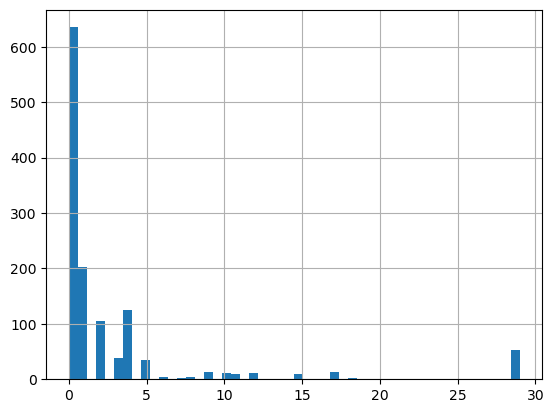

In [23]:
# NOTE this uses OSDS_FLIK_ID (the OSDS Uid to Flik ID key) from above

paths_path = os.path.join("..", "Projected_data/Coast_Usage_Flikr/Processed", 'Statewide_flikr_visitation.shp')
columns_nams = [field.name for field in arcpy.ListFields(paths_path)]
columns_nams.pop(1)  # remove stupid shape col
temparr = arcpy.da.FeatureClassToNumPyArray(paths_path, columns_nams)
tempdf =  pd.DataFrame(temparr)
carelist = ['Flikr_ID', 'UserDays']  # cut to only wanted cols
Flk_userTemp = tempdf[carelist].copy()

# Do the merge with flikrcells
usedays_merge = OSDS_FLIK_ID.merge(Flk_userTemp, on='Flikr_ID', how='left')
carelist2 = ['Uid', 'UserDays']  # cut to only wanted cols

USERDAYS = usedays_merge[carelist2]
USERDAYS.to_csv(os.path.join(intermidiate_DataFramesPath, "USERDAYS.csv"))

Hist_and_stats_on_DF(USERDAYS, "UserDays")

## Lifeguard towers / swim beaches
There are no lifeguard towers on Molokai. 
This shapefile was generated through searching websites that recommended beaches to swim, specifically the official HI tourism website: https://www.gohawaii.com/islands/molokai/things-to-do/beaches was used along with Visit Molokai https://visitmolokai.com/wp/molokai-beaches/ 

In [52]:
# input datasets
Flik_dots_path = os.path.join("..", "Projected_data/ImpactZones_Flik_ID/GeographicFlikr_data", 'State_Gridded_Coast_WGS84_pts.shp')
variable_pts_path = os.path.join("..", "Projected_data/Swim_beaches", 'Molokai_Swim_Beaches.shp')

# make silly arc layers
arcpy.MakeFeatureLayer_management (Flik_dots_path, "Flik_dots")
arcpy.MakeFeatureLayer_management (variable_pts_path, "variable_pts")

# Select Flik cells(dots) by proximity to LG towers
Selection = arcpy.SelectLayerByLocation_management("Flik_dots", "WITHIN_A_DISTANCE", "variable_pts", "550 meters", "NEW_SELECTION","NOT_INVERT")
arcpy.CopyFeatures_management(Selection, os.path.join(tempspace, "selected_variables.shp"))

# read data from shapefile 
extracted_points_path = os.path.join(tempspace, "selected_variables.shp")
arcpy.TableToTable_conversion(extracted_points_path, tempspace, 'extracted_all.csv') # Create a rational file format
# Create a rational PanDataframe
Extracted_All = pd.read_csv(os.path.join(tempspace, 'extracted_all.csv'))

# Cut out unneded columns and save final dataframe  (Note that the tempframe contains the actual flikr_ID of the guard station for each)
want_cols = ['Uid', 'Swim_beach']
tempframe = Extracted_All.merge(OSDS_FLIK_ID, on="Flikr_ID", how="left")
tempframe["Swim_beach"] = True
SWIM_BEACHES = tempframe[want_cols]
SWIM_BEACHES.to_csv(os.path.join(intermidiate_DataFramesPath, "SWIM_BEACHES.csv"))

# print analysics on how OSDS file from top cell, matches up with results
print("There are {} points draining to swim beaches".format(len(SWIM_BEACHES)))
print("There are {} OSDS shp points".format(len(OSDS)))

There are 136 points draining to swim beaches
There are 1280 OSDS shp points


## Coastal Ecosystem impact valuations from Marine Biology Group
Resource fish are coral reef fish species that make up a substantial proportion of non-commercial and commercial catch. Therefore this does not represent total fish biomass on the reef, but the subset of fish biomass that directly supports fishing and feeds local communities. Reef fish biomass has been shown to negatively correlate with effluent from OSDS in the Hawaiian Islands (Foo et al., 2021). 
  
The Hawaii Monitoring and Reporting Collaborative (HIMARC) produced predicted maps of standing resource fish biomass and the theoretical recovery potential of resource fish biomass if effluent from on-site sewage disposal systems were eliminated (Donovan et al., 2020). 

A combined ranking of these 2 resource fish biomass datasets were derived for the cesspool conversion prioritization. Each of these datasets were summarized by median biomass within zones spanning 0 - 15 m depth corresponding to 1 km segments of shoreline.

Shore based raster data was mapped onto 250 m grid polygons with 2 added columns ("Coral_rank", and "RFish_rank"). Both have integer values 1-4 where 1 = highest priority and 4 = lowest priority. Data in Pearl Harbor and Hawaii Kai Marina cells to NULL values since we have no reef data there.

New datasets were generously generated for Molokai by the HIMARC group in 2025

Average Coral_rank is 2.38671875
Max Coral_rank is 4
Min Coral_rank is 1


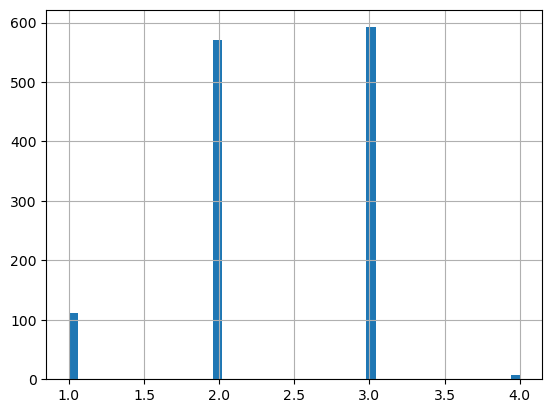

In [25]:
paths_path = os.path.join("..", "Projected_data/Ecosystem", 'Molokai_CoastGrid_250m_reefAtts_20250401.shp')
columns_nams = [field.name for field in arcpy.ListFields(paths_path)]
columns_nams.pop(1)  # remove stupid shape col
temparr = arcpy.da.FeatureClassToNumPyArray(paths_path, columns_nams)
tempdf =  pd.DataFrame(temparr)

### This should not be needed with the new .._20250401.shp  But will need to modify when doing new update  ###
# Do a replacement of the Flikr ID to include the island name 
#tempdf['Island'] = tempdf['Island'].str.replace('Hawaii','BI')
#tempdf["new_flik_ID"] = tempdf["Flikr_ID"]+"_"+tempdf["Island"]
#tempdf["Flikr_ID"] = tempdf["new_flik_ID"]

carelist = ['Flikr_ID', 'Coral_rank', "RFish_rank"]  # cut to only wanted cols
Flk_EcoTemp = tempdf[carelist].copy()

# Do the merge with flikrcells for corals
coral_merge = OSDS_FLIK_ID.merge(Flk_EcoTemp, on='Flikr_ID', how='left')
carelist2 = ['Uid', 'Coral_rank']  # cut to only wanted cols

CORAL = coral_merge[carelist2]
CORAL.to_csv(os.path.join(intermidiate_DataFramesPath, "CORAL.csv"))

Hist_and_stats_on_DF(CORAL, "Coral_rank")

Average RFish_rank is 1.8609375
Max RFish_rank is 4
Min RFish_rank is 1


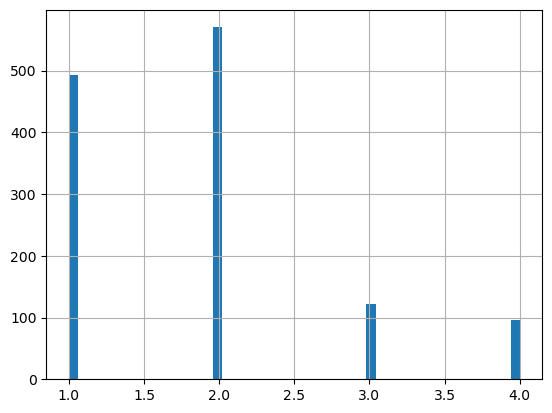

In [26]:
# Do the merge with flikrcells for fish    

# Note coral_merge which came from Flk_EcoTemp exists from the cell above 

carelist3 = ['Uid', 'RFish_rank']  # cut to only wanted cols
FISH = coral_merge[carelist3]
FISH.to_csv(os.path.join(intermidiate_DataFramesPath, "FISH.csv"))

Hist_and_stats_on_DF(FISH, "RFish_rank")

# Ocean Circulation proxy
##### Wave Power (in KW/m) Long-term Mean, 2000-2013 – Statewide

Refs: Kappel, C.V., K.A. Selkoe, and Ocean Tipping Points (OTP). 2017. Wave Power Long-term Mean, 2000-2013 - Hawaii. Distributed by the Pacific Islands Ocean Observing System (PacIOOS). http://pacioos.org/metadata/hi_otp_all_wave_avg.html. Accessed 9-8-21.

Wedding LM, Lecky J, Gove JM, Walecka HR, Donovan MK, et al. (2018) Advancing the integration of spatial data to map human and natural drivers on coral reefs. PLOS ONE 13(3): e0189792. https://doi.org/10.1371/journal.pone.0189792.

Average Wave_pwr is 8.502659989743076
Max Wave_pwr is 31.0620708466
Min Wave_pwr is 0.150198996067


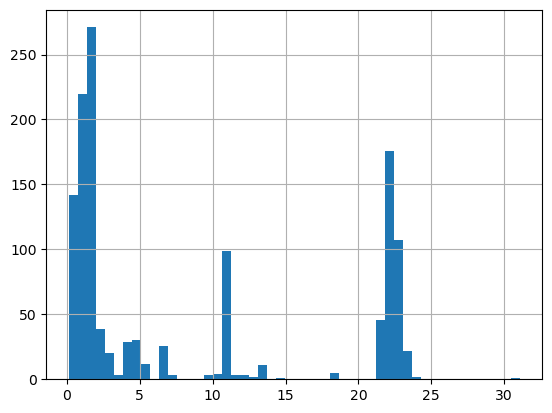

In [27]:
paths_path = os.path.join("..", "Projected_data/Coastal_Circulation", 'Wave_power_KWm_Flikr_pts.shp')
columns_nams = [field.name for field in arcpy.ListFields(paths_path)]
columns_nams.pop(1)  # remove stupid shape col
temparr = arcpy.da.FeatureClassToNumPyArray(paths_path, columns_nams)
tempdf =  pd.DataFrame(temparr)

carelist = ['Flikr_ID', 'Wave_pwr']  # cut to only wanted cols
Flk_OcircTemp = tempdf[carelist].copy()

# Do the merge with flikrcells for corals
Ocirc_merge = OSDS_FLIK_ID.merge(Flk_OcircTemp, on='Flikr_ID', how='left')
carelist2 = ['Uid', 'Wave_pwr']  # cut to only wanted cols

WAVE_POWER = Ocirc_merge[carelist2]
WAVE_POWER.to_csv(os.path.join(intermidiate_DataFramesPath, "WAVE_POWER.csv"))

Hist_and_stats_on_DF(WAVE_POWER, "Wave_pwr")

# Consolidation into different areas and association of metadata

## Add Census Track IDs


In [5]:
# Create the key to join OSDS points to Census blocks 
In_polygons = os.path.join("..", "Projected_data/Census", '2010_Census_Tracts_Clean.shp')
In_points = osds_path
want_cols = ['Uid', 'Track_ID']
Level = 'Tracts'

TRACK_ID = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=True, Level=Level)
TRACK_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "TRACK_ID.csv"))

## Add census block group IDs 


In [6]:
# Create the key to join OSDS points to Census blockgroups
In_polygons = os.path.join("..", "Projected_data/Census", '2010_Census_Block_Groups_Clean.shp')
In_points = osds_path
want_cols = ['Uid', 'BlockGp_ID']
Level = 'Block_Groups'

BLOCKGROUP_ID = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=True, Level=Level)
BLOCKGROUP_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "BLOCKGROUP_ID.csv"))

## Add census block IDs 

In [7]:
# Create the key to join OSDS points to Census blocks 
In_polygons = os.path.join("..", "Projected_data/Census", '2010_Census_Blocks_Clean.shp')
In_points = osds_path
want_cols = ['Uid', 'BlockBk_ID']
Level = 'Blocks'

BLOCK_ID = Census_data_joining(In_points, In_polygons, want_cols, Save_meta=True, Level=Level)
BLOCK_ID.to_csv(os.path.join(intermidiate_DataFramesPath, "BLOCK_ID.csv"))

## Label if point is within a 2017 cesspool priority zone
Should be none for Molokai as there dont seem to be any 2017 priority zones there 

In [8]:
In_polygons = os.path.join("..", "Projected_data/Old_2017_priority_areas", 'Old_2017_priority_areas.shp')
new_col_name = 'In_2017_CP_zone'
In_points = osds_path

IN_2017_CP = Find_points_inside_polys(In_points, In_polygons, new_col_name)
IN_2017_CP.to_csv(os.path.join(intermidiate_DataFramesPath, "IN_2017_CP.csv"))

print_stats_on_bool_layers(IN_2017_CP)

number of affected points = 0
number of total systems = 1280
percent of systems affected = 0.0


# Merge together all factors


In [10]:
mergeframes_list = [BLOCK_ID, BLOCKGROUP_ID, TRACK_ID, OSDS_FLIK_ID, USERDAYS, SWIM_BEACHES,
                    COASTLINE, MUN_WELLS, DOM_WELLS, STREAMS, SOILS_NRCS, RAINFALL,  SLOPE, OSDS_DENSITY, WETLANDS,
                    DTOWATER, SLR_2030_yes, SLR_2050_yes, SLR_2100_yes, WellCZ_B_yes, WellCZ_C_yes, 
                    FISH, CORAL, IN_2017_CP, WAVE_POWER]  # ELEVATION  # PPL_PER_HOS,


 
# Print out specs on the different lists
for i in mergeframes_list: 
    print(f"{i.columns}, length = {len(i)}")   

# Merge dataframes into master
OSDS_Master = OSDS.copy()
for i in mergeframes_list:
    OSDS_Master = OSDS_Master.merge(i, on="Uid", how="left")

# Some post processing 
OSDS_Master["dist2_Strm_Wtlnd_m"] = OSDS_Master[["dist2_Streams_m", "dist2_Wetlands_m"]].min(axis=1)
OSDS_Master.drop_duplicates(subset=['Uid'], keep="first", inplace=True)

OSDS_Master.to_csv(os.path.join(".", "Outputs/OSDS_Dots", 'OSDS_MASTER_RiskFactors_v6.csv'), index =False)
print("total length is {}".format(len(OSDS_Master)))

Index(['Uid', 'BlockBk_ID'], dtype='object'), length = 1280
Index(['Uid', 'BlockGp_ID'], dtype='object'), length = 1280
Index(['Uid', 'Track_ID'], dtype='object'), length = 1280
Index(['Uid', 'Flikr_ID', 'Flikr_X', 'Flikr_Y'], dtype='object'), length = 1280
Index(['Uid', 'UserDays'], dtype='object'), length = 1280
Index(['Uid', 'Swim_beach'], dtype='object'), length = 136
Index(['Uid', 'dist2_coast_m'], dtype='object'), length = 1280
Index(['Uid', 'dist2_MunWells_m'], dtype='object'), length = 1280
Index(['Uid', 'dist2_DomWells_m'], dtype='object'), length = 1280
Index(['Uid', 'dist2_Streams_m'], dtype='object'), length = 1280
Index(['Uid', 'nrcs_DtoBrock', 'nrcs_FloodFreq', 'nrcs_septic_dominant',
       'nrcs_septic_least', 'nrcs_septic_most', 'nrcs_ksat_hi', 'nrcs_ksat_lo',
       'nrcs_ksat_rep', 'nrcs_rockFrag3in'],
      dtype='object'), length = 1280
Index(['Uid', 'rainfall_in'], dtype='object'), length = 1280
Index(['Uid', 'slope_deg'], dtype='object'), length = 1275
Index(['Ui

# Ranks and weights 

Ingests the OSDS data with risk factors assigned and develops the **risk-factor scores** as well as applying **weights** to each parameter to develop a final **prioritization score.**

In [11]:
# Read in initial thresholds off of csv
thresholds =   pd.read_csv(os.path.join("..", "Projected_data", 'Thresholds_and_Weights_v7_expWeight.csv'), index_col=0)
numcols=['W1_base', 'W2_eco', 'W3_anthro', 'T1', 'T2', 'T3']
thresholds[numcols] = thresholds[numcols].apply(pd.to_numeric, errors='coerce', axis=1)

In [12]:
# Load datastets
OSDS_Master = pd.read_csv(os.path.join("Outputs/OSDS_Dots", 'OSDS_MASTER_RiskFactors_v6.csv'))
OSDS_Master.drop_duplicates(subset=['Uid'], keep="first", inplace=True)
baseCols = ['X', 'Y', 'Island', 'TMK', 'Uid', 'In_2017_CP_zone',
             'BlockBk_ID', 'BlockGp_ID', 'Track_ID', 'Flikr_ID']  # 'PepPerHos'
priority_master = OSDS_Master[baseCols].copy()


# Identify variables to consider and rank
Rank_Cols = ['Soil_Suitability_Rank',  'SLR_Rank', 'WELLCZ_Rank', 'dist2_coast_m_Rank', 
             'dist2_Strm_Wtlnd_m_Rank', 'rainfall_in_Rank', 'dist2_MunWells_m_Rank', 
             'dist2_DomWells_m_Rank', 'Dep_to_Water_m_Rank', 'OSDS_Density_perAcre_Rank',
             'Swim_beach_Rank', 'UserDays_Rank', 'Fish_Rank', 'Coral_Rank', 'Wave_pwr_Rank']  # , 'PepPerHos_Rank'

In [13]:
# Deal with some naming issues
OSDS_Master['nrcs_ksat_rep_slowwater'] = OSDS_Master['nrcs_ksat_rep'].copy()
OSDS_Master['nrcs_ksat_rep_filtering'] = OSDS_Master['nrcs_ksat_rep'].copy()
OSDS_Master['nrcs_ksat_rep_bottomseepage'] = OSDS_Master['nrcs_ksat_rep'].copy()

## Create a consolidated soil suitability rank that takes into consideration: 
- Depth to Bedrock or Cemented Pan  100%       
- Flooding or Ponding               100%  
- Filtering Capacity (ft/d)         100% 
- Slow Water Movement (ft/d)        100% 
- Seepage From Bottom Layer (ft/d)  33%
- Slope (percent)                   33% 
- Percent Rock Fragments > 3”       33%   

In [14]:
# create a Soil suitability rank, with all 7 parameters equally weighted  ( high values = LEAST SUITABLE)

### Note  Pandas telling you that its replace() downcasting behavior is changing in a future version.
pd.set_option('future.no_silent_downcasting', False)  # Option 1 — Tell Pandas you’re fine with the old behavior:

plist =  ['nrcs_ksat_rep_slowwater', 'nrcs_DtoBrock', 'nrcs_ksat_rep_filtering', 
          'nrcs_ksat_rep_bottomseepage', 'slope_deg', 'nrcs_rockFrag3in']

# Prioritize thresholded ones
framedic_Soil_temp = {}
for idx, col in enumerate(plist):
    Ty, T1, T2, T3 = read_3_thresholds(thresholds, col)
    framedic_Soil_temp["Rank_{}".format(col)] = cut_by_three_numeric_thresholds(OSDS_Master, col, Ty, T1, T2, T3)
    
    # Soil Type Flood Frequency 
FLOOD_FREQ = OSDS_Master[["Uid", 'nrcs_FloodFreq']].copy()
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "None", 'nrcs_FloodFreq_Rank'] = "P4"
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "Rare", 'nrcs_FloodFreq_Rank'] = "P3"
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "Occasional", 'nrcs_FloodFreq_Rank'] = "P2"
FLOOD_FREQ.loc[FLOOD_FREQ['nrcs_FloodFreq'] == "Frequent", 'nrcs_FloodFreq_Rank'] = "P1"
framedic_Soil_temp["Rank_nrcs_FloodFreq"] = FLOOD_FREQ[["Uid", 'nrcs_FloodFreq_Rank']]

# Change out the P values with numeric values
for key in framedic_Soil_temp.keys():
    framedic_Soil_temp[key].replace(to_replace = "P1", value = 99, inplace = True)
    framedic_Soil_temp[key].replace(to_replace = "P2", value = 66, inplace = True)
    framedic_Soil_temp[key].replace(to_replace = "P3", value = 33, inplace = True)
    framedic_Soil_temp[key].replace(to_replace = "P4", value = 1, inplace = True)
    
# Merge dataframes into master
SOIL_MASTER = priority_master.copy()
for i in framedic_Soil_temp.keys():
    SOIL_MASTER = SOIL_MASTER.merge(framedic_Soil_temp[i], on="Uid", how="left")   
    
# This contains the internal weightings for the soil suitability rank
Prioritization_vars_dic = {
    'nrcs_ksat_rep_slowwater_Rank':1,
    'nrcs_ksat_rep_bottomseepage_Rank':0.33,
    'nrcs_ksat_rep_filtering_Rank':1,
    'nrcs_DtoBrock_Rank':1,
    'nrcs_FloodFreq_Rank':1,
    'slope_deg_Rank':0.33,
    'nrcs_rockFrag3in_Rank':0.33  }

# Run the interlal weightings for the suitibility rank
for var in Prioritization_vars_dic.keys():
    SOIL_MASTER[var] = SOIL_MASTER[var]*Prioritization_vars_dic[var]

SOIL_MASTER['Soil_Suitability_Rank'] = SOIL_MASTER[list(Prioritization_vars_dic.keys())].mean(axis=1)
# Save the consolidated soil rank by itself
SOIL_MASTER = SOIL_MASTER[['Uid', 'Soil_Suitability_Rank']]

C:\Users\CS\AppData\Local\Temp\ipykernel_7900\2939506229.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  framedic_Soil_temp[key].replace(to_replace = "P4", value = 1, inplace = True)
C:\Users\CS\AppData\Local\Temp\ipykernel_7900\2939506229.py:26: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  framedic_Soil_temp[key].replace(to_replace = "P2", value = 66, inplace = True)
C:\Users\CS\AppData\Local\Temp\ipykernel_7900\2939506229.py:27: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future 

## Prioritization Function: Threshold then 1d-convective dispersive decay: 100 pt scale

In [15]:
# Threshold then exponential decay
def threshold_then_decay(OSDS_df, col_name, T1, ascending):
    # reminder, 100 is bad/more impactful, 0 is good/least impactful
    
    return_frame = OSDS_df[["Uid", col_name]].copy()
    
    scaler = return_frame[col_name].median()*.1   # this scale factor controls the shape of the exponential decay and essentially revises the value at which scores transition from high (90s and above) to lower
    #print("for {} scaler is {}".format(col_name, scaler))
    
    if ascending == True:
        return_frame.loc[return_frame[col_name] < T1, '{}_Rank'.format(col_name)] = 100
        return_frame.loc[return_frame[col_name] > T1, '{}_Rank'.format(col_name)] = 100*((T1+scaler)/(return_frame[col_name]+scaler))
       
        
    if ascending == False:
        return_frame.loc[return_frame[col_name] > T1, '{}_Rank'.format(col_name)] = 100
        return_frame.loc[return_frame[col_name] < T1, '{}_Rank'.format(col_name)] = 100*(return_frame[col_name]+scaler)/(T1+scaler)

    return_frame = return_frame[["Uid",'{}_Rank'.format(col_name)]]
    
    return return_frame 


# a 0 to 100 scaler function
def MY_minmaxscaler_dfCol(col, reverse=False):   
    # Reverse True indicates that bigger data values   (e.g dist to coast) get smaller ranks meaning less impact 
    # Reverse False indicates that smaller data values (e.g OSDS_density)  get smaller ranks meaning less impact  
    
    mx = col.max()
    mn = col.min()   
    if reverse==False:
        scaled_series = 100*(col-mn)/(mx-mn)       
    if reverse==True:
        scaled_series = 100*(col-mx)/(mn-mx)
    
    return scaled_series

In [16]:
framedic_decay = {}

# Loop over the non-soil parameters and add their ranks to the dic
plist_ascending =  ['dist2_coast_m', 'dist2_Strm_Wtlnd_m', 'dist2_MunWells_m',
                    'dist2_DomWells_m', 'Dep_to_Water_m', 'rainfall_in', 'Wave_pwr'] 
plist_decending =  ['OSDS_Density_perAcre', 'UserDays']

for idx, col in enumerate(plist_ascending):
    Ty, T1, T2, T3 = read_3_thresholds(thresholds, col)
    framedic_decay["Rank_{}".format(col)] = threshold_then_decay(OSDS_Master, col, T1, ascending=True)

for idx, col in enumerate(plist_decending):
    Ty, T1, T2, T3 = read_3_thresholds(thresholds, col)
    framedic_decay["Rank_{}".format(col)] = threshold_then_decay(OSDS_Master, col, T1, ascending=False) 

In [17]:
# Add in the non-loopable (thresholded) parameters to the framedic

# Add the soil ranking
framedic_decay['SOIL_MASTER'] = SOIL_MASTER

# Sea Level Rise  'InSLR2030', 'InSLR2050',  'InSLR2100'
SLR = OSDS_Master[["Uid", 'InSLR2030', 'InSLR2050',  'InSLR2100']].copy()
SLR['SLR_Rank'] = 0
SLR.loc[SLR['InSLR2100'] == True, 'SLR_Rank'] = 33
SLR.loc[SLR['InSLR2050'] == True, 'SLR_Rank'] = 66
SLR.loc[SLR['InSLR2030'] == True, 'SLR_Rank'] = 100
framedic_decay["Rank_SLR"] = SLR[["Uid", 'SLR_Rank']]

# Well Capture Zones
WELLCZs = OSDS_Master[["Uid", 'In_WellCZ_B', 'In_WellCZ_C']].copy()
WELLCZs['WELLCZ_Rank'] = 0
WELLCZs.loc[WELLCZs['In_WellCZ_C'] == True, 'WELLCZ_Rank'] = 50
WELLCZs.loc[WELLCZs['In_WellCZ_B'] == True, 'WELLCZ_Rank'] = 100
framedic_decay["Rank_WELLCZ"] = WELLCZs[["Uid", 'WELLCZ_Rank']]

# Swim beaches
SWIMBEACH = OSDS_Master[["Uid", 'Swim_beach']].copy()
SWIMBEACH['Swim_beach_Rank'] = 0
SWIMBEACH.loc[SWIMBEACH['Swim_beach'] == True, 'Swim_beach_Rank'] = 100
framedic_decay["Rank_Swim_beach"] = SWIMBEACH[["Uid", 'Swim_beach_Rank']]

# Fish   # Note that the original col was named RFish_rank with a small r the Fish_Rank with big R is the 0-100 score
FISHY = OSDS_Master[["Uid", 'RFish_rank']].copy()
FISHY['Fish_Rank'] = 0
FISHY.loc[FISHY['RFish_rank'] == 1, 'Fish_Rank'] = 100
FISHY.loc[FISHY['RFish_rank'] == 2, 'Fish_Rank'] = 66
FISHY.loc[FISHY['RFish_rank'] == 3, 'Fish_Rank'] = 33
FISHY.loc[FISHY['RFish_rank'] == 4, 'Fish_Rank'] = 0
framedic_decay["Rank_Fish"] = FISHY[["Uid", 'Fish_Rank']]

# Coral    Note that the original col was named Coral_rank with a small r the Coral_Rank with big R is the 0-100 score
CORALY = OSDS_Master[["Uid", 'Coral_rank']].copy()
CORALY['Coral_Rank'] = 0
CORALY.loc[CORALY['Coral_rank'] == 1, 'Coral_Rank'] = 100
CORALY.loc[CORALY['Coral_rank'] == 2, 'Coral_Rank'] = 66
CORALY.loc[CORALY['Coral_rank'] == 3, 'Coral_Rank'] = 33
CORALY.loc[CORALY['Coral_rank'] == 4, 'Coral_Rank'] = 0
framedic_decay["Rank_Coral"] = CORALY[["Uid", 'Coral_Rank']]


# Add number of people per household
####Pep_hos = OSDS_Master[["Uid", 'PepPerHos']].copy()
####Pep_hos['PepPerHos_Rank'] = MY_minmaxscaler_dfCol(OSDS_Master['PepPerHos'], reverse=False)
####framedic_decay["Rank_PepPerHos"] = Pep_hos[["Uid", 'PepPerHos_Rank']]

1280


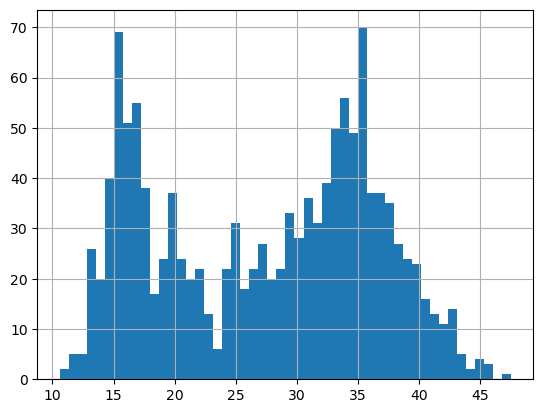

In [18]:
# Merge dataframes into master
DECAY_PRIORITY_MASTER = priority_master.copy()
for i in framedic_decay.keys():
    DECAY_PRIORITY_MASTER = DECAY_PRIORITY_MASTER.merge(framedic_decay[i], on="Uid", how="left")

# Create the single mean rank
DECAY_PRIORITY_MASTER['Priority_mean'] = DECAY_PRIORITY_MASTER[Rank_Cols].mean(axis=1)

print(len(DECAY_PRIORITY_MASTER))
DECAY_PRIORITY_MASTER['Priority_mean'].hist(bins=50)

#Print out a copy to use in the sensitivity testing notebook
DECAY_PRIORITY_MASTER.to_csv(os.path.join(tempspace, "DECAY_PRIORITY_MASTER.csv"), index=False)

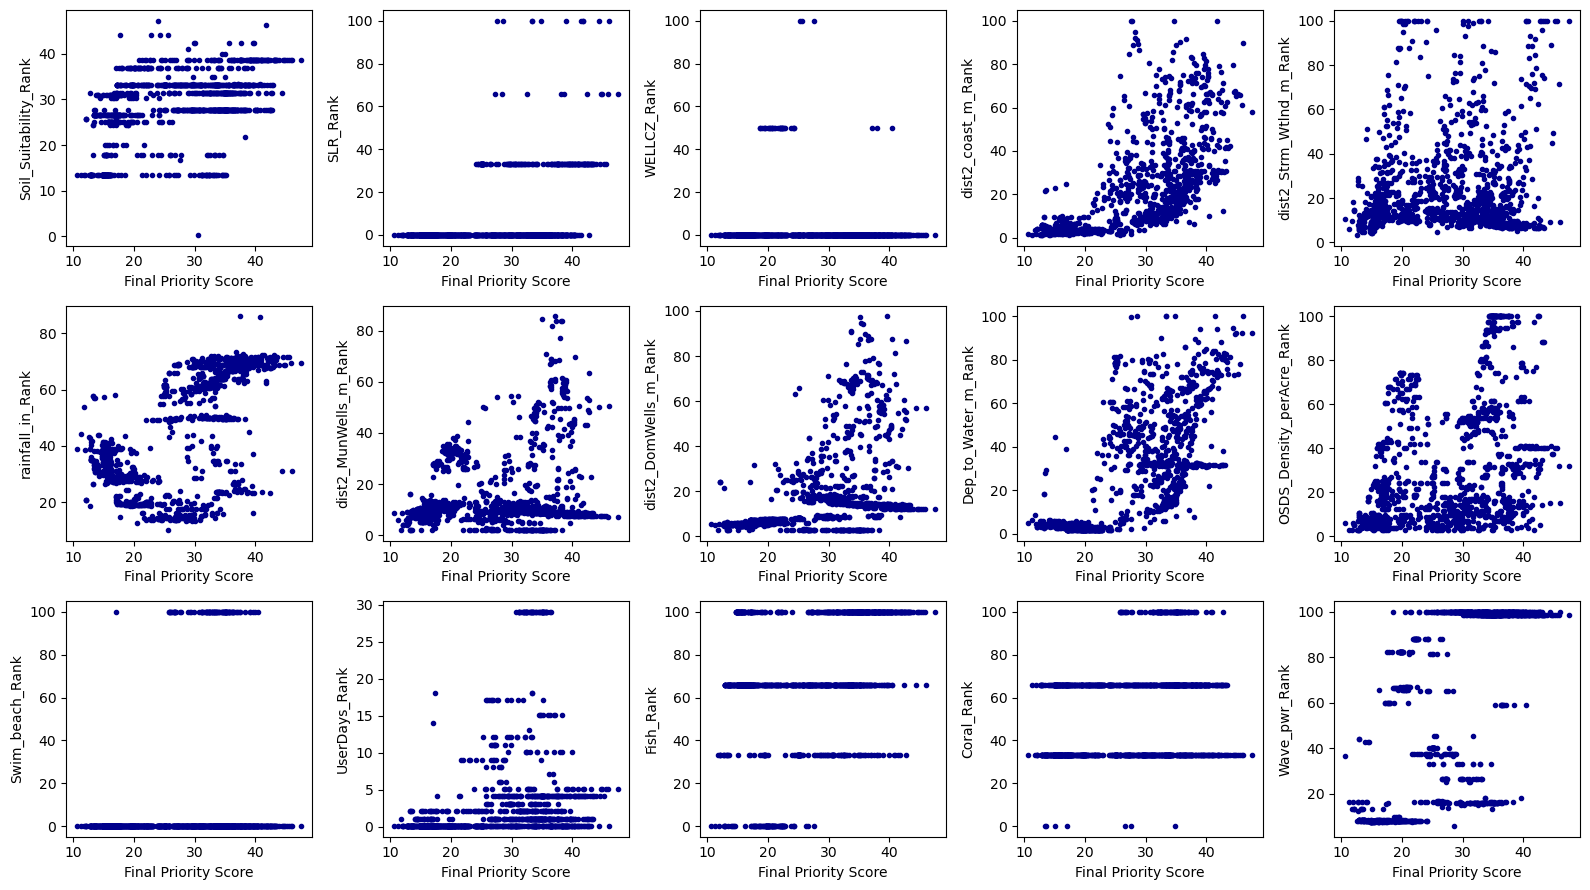

In [19]:
# Plot the comparison between individual risk factor scores and the final priority score.  
fig, ax = plt.subplots(3,5, figsize=(16, 9))
for idx, col in enumerate(Rank_Cols):
    ax = plt.subplot(3,5,idx+1)
    x = DECAY_PRIORITY_MASTER['Priority_mean']
    y = DECAY_PRIORITY_MASTER[col]
    plt.scatter(x, y, marker=".", color='darkblue')
    plt.ylabel(col); plt.xlabel('Final Priority Score')
    plt.tight_layout()

# Base Scenario each factor Weighted between 1-5 by expert panel 

This framework provides the ability to weigh the influence of each risk factor on the final priority score for each unit. Weighting can be done by multiplying the individual parameter score by a weight value, for example a weight value of two (2) can be used if it is desired for a parameter to be twice as important as those with a weighting value of one (1).


Note, at one point I was scaling the final priority score into 0-100 space for comparisons between scenarios, but this might not be the best idea. used this syntax BASE_PRIORITY_MASTER['Weighted_Priority_mean'] = MY_minmaxscaler_dfCol(BASE_PRIORITY_MASTER['Weighted_Priority_mean'], reverse=False)

C:\Users\CS\AppData\Local\Temp\ipykernel_7900\1642778140.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  BASE_PRIORITY_MASTER['In_2017_CP_zone'].fillna(False, inplace=True)
C:\Users\CS\AppData\Local\Temp\ipykernel_7900\1642778140.py:15: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'False' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  BASE_PRIORITY_MASTER['In_2017_CP_zone'].fillna(False, inplace=T

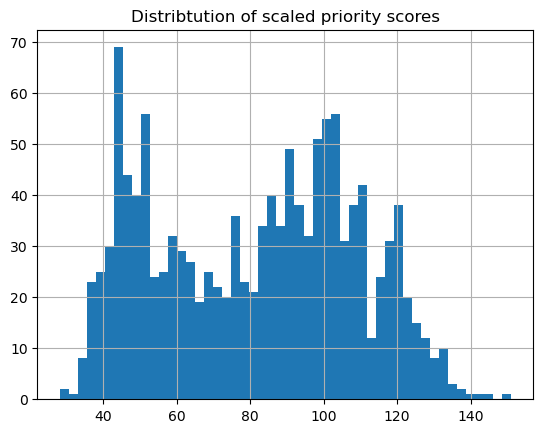

In [20]:
BASE_PRIORITY_MASTER = DECAY_PRIORITY_MASTER[baseCols].copy()  # Create base for weighting

# Apply weights to each column
for i in Rank_Cols: 
    col = i.replace("_Rank", "")
    weight = thresholds.loc[col]['W1_base']
    
    # Average the two methods and apply weights
    BASE_PRIORITY_MASTER[i] = DECAY_PRIORITY_MASTER[i]*weight
    
    
BASE_PRIORITY_MASTER['Weighted_Priority_mean'] = BASE_PRIORITY_MASTER[Rank_Cols].mean(axis=1)

# prepare the final to be able to determine if more than 50% of the OSDS units are in a Priority zone (average wont count NaN as 0)
BASE_PRIORITY_MASTER['In_2017_CP_zone'].fillna(False, inplace=True)

# Plots 
BASE_PRIORITY_MASTER['Weighted_Priority_mean'].hist(bins=50)
plt.title('Distribtution of scaled priority scores')

BASE_PRIORITY_MASTER.to_csv(os.path.join(tempspace, "BASE_PRIORITY_MASTER.csv"))

## Consolidate Individual OSDS units into Census Polygon groups:
Different resolutions include: - 2010 Census Tracks, - 2010 Census Block Groups, - 2010 Census Blocks

This assigns the average final priority score of the OSDS units that fall within each geographic polygon to the census unit. A parameter to exclude units that do not contain some minimum number of OSDS is available to avoid biasing the prioritization by areas with an insignificant number of OSDS units


#####  Also delineate Priority categories (High, Med Low) Categories are defined primarily by our ranking¶
- with top 10% highest priority scores as High
- top 11% to 50% as Medium
- Bottom 50% as low 

Text(0, 0.5, 'Frequency')

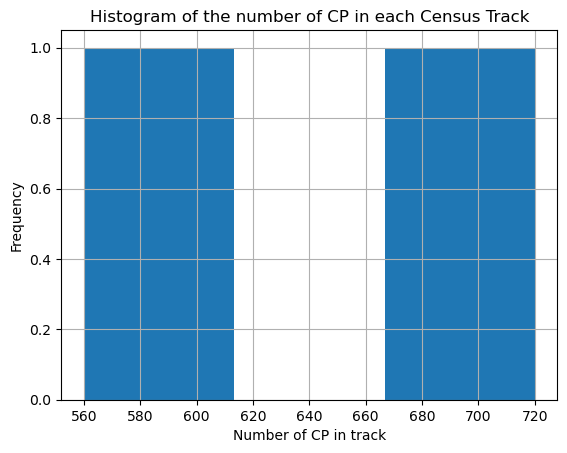

In [21]:
# Consolidate the many CP units into tracks, remembering that the  Omit < is set at 25 
UnitCol = 'Track_ID'
Tracks_priority_frame_base = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=25)
Tracks_priority_frame_base['OSDS_count'].hist(bins=len(Tracks_priority_frame_base['OSDS_count'].unique())+1)   # adding a +1 because the histogram looked weird with only 2 tracks in the frame
plt.title("Histogram of the number of CP in each Census Track"); plt.xlabel("Number of CP in track"); plt.ylabel("Frequency")

In [22]:
# Cut columns to desired ones 
WantCols = ['Track_ID', 'Final_Prioity_Score','Soil_Suitability_Rank', 'SLR_Rank', 'WELLCZ_Rank',
       'dist2_coast_m_Rank', 'dist2_Strm_Wtlnd_m_Rank', 'rainfall_in_Rank',
       'dist2_MunWells_m_Rank', 'dist2_DomWells_m_Rank', 'Dep_to_Water_m_Rank',
       'OSDS_Density_perAcre_Rank', 'Swim_beach_Rank', 'UserDays_Rank', "Fish_Rank", "Coral_Rank", 'Wave_pwr_Rank',
       'OSDS_count']   # will delete OSDS count once is in name col   #  'PepPerHos_Rank',
 
compare_priority_score_Track = Tracks_priority_frame_base[WantCols]
compare_priority_score_Track = compare_priority_score_Track.sort_values("Final_Prioity_Score", ascending=False)


# Get and set track names to the index
trackpath = os.path.join("..", "Projected_data/Census/With_2017_priority", '2010_Census_Tracts_Meta_w2017.shp') 
Track_meta = get_track_names(trackpath, "Track_ID")  # in the functions file
compare_priority_score_Track = compare_priority_score_Track.merge(Track_meta, on='Track_ID', how='left')
# Add on the # of CPs to the index 
compare_priority_score_Track['Name_ID'] = compare_priority_score_Track['Name_ID']+": CPs="+compare_priority_score_Track['OSDS_count'].astype(str)
compare_priority_score_Track = compare_priority_score_Track.set_index('Name_ID')                                  # Convert to pandas bliss
del compare_priority_score_Track['Track_ID'];  del compare_priority_score_Track['OSDS_count']

# make 
renamas = {'Final_Prioity_Score':'Final Prioity Score', 
            'Soil_Suitability_Rank':'Soil Suitability',
            'SLR_Rank':'Sea Level Rise',
            'WELLCZ_Rank':'Well Capture Zones',
            'dist2_coast_m_Rank':'Dist. to Coast',
            'dist2_Strm_Wtlnd_m_Rank':'Dist. to Strms/Wtlnds',
            'rainfall_in_Rank':'Rainfall',
            'dist2_MunWells_m_Rank':'Dist. to Muni. Wells',
            'dist2_DomWells_m_Rank':'Dist. to Dom. Wells',
            'Dep_to_Water_m_Rank':'Depth to GW',
            'OSDS_Density_perAcre_Rank':'OSDS Density',
            'Swim_beach_Rank':'Swim Beaches',
            'UserDays_Rank':'Coastline Usage',
            'Fish_Rank':'Reef Fishery Priority',
            'Coral_Rank':'Coral Reef Priority', 
            'Wave_pwr_Rank': 'Wave Power'}    # , 'PepPerHos_Rank':'People per House'}

compare_priority_score_Track.rename(columns=renamas, inplace=True)     # Rename to col that you want

In [23]:
compare_priority_score_Track

,Final Prioity Score,Soil Suitability,Sea Level Rise,Well Capture Zones,Dist. to Coast,Dist. to Strms/Wtlnds,Rainfall,Dist. to Muni. Wells,Dist. to Dom. Wells,Depth to GW,OSDS Density,Swim Beaches,Coastline Usage,Reef Fishery Priority,Coral Reef Priority,Wave Power
Name_ID,,,,,,,,,,,,,,,,
: East Moloka'i: T#318: CPs=720,99.924734,63.998648,28.079167,1.458333,124.913255,73.629437,107.329039,87.528172,110.599660,171.235993,148.247935,6.388889,4.570430,240.070833,155.641667,176.312773
: West Moloka'i: T#295: CPs=560,57.786728,50.008064,2.496429,8.571429,24.822201,67.704747,67.001379,62.692798,21.451707,38.799164,102.112595,29.285714,7.945626,178.012500,165.546429,40.350147


The island of Molokai contains 1280 cesspools and has a total of 3 census tracts although only 2 tracts contained more than 25 cesspools and were thus categorized with the HCPT. Of these tracts 50% or 1 of them were categorized as high (1) priority (classified as the top 25% of census tracts statewide), 0% or 0 of them were categorized as medium (2) priority and 50% or 1 of them were categorized as low (3) priority. The total number of cesspools on Molokai catergorized as high (1) priority was 720, with 0 and 560 as medium (2) and low (3) priority, respectivly.


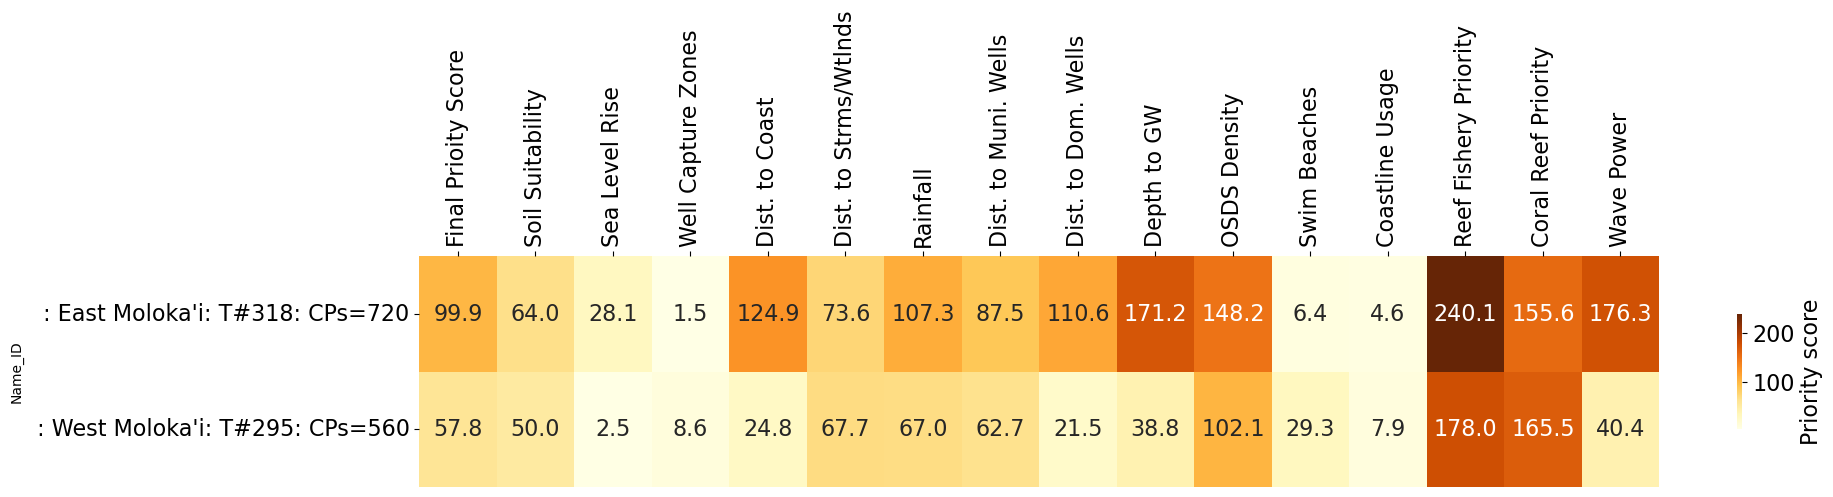

In [51]:
# Plot out comparison heatmap 

Total_census_tracts = 3

fig, ax = plt.subplots(figsize=(20, 3))
total_num = len(compare_priority_score_Track)
#plt.title("Ranks for all {} census Tracks".format(total_num), fontsize=18, y=1.05)
plt.tick_params(axis='x', which='major', labelsize=16, labelbottom = False, bottom=False, top = True, labeltop=True)
plt.xticks(rotation=70)
plt.tick_params(axis='y', which='major', labelsize=16)


# bar_label = "Priority score. Note total # of census units considered is {}".format(len(Tracks_priority_frame_base['OSDS_count']))  # simplify label 
bar_label = "Priority score" 

#g = sns.heatmap(compare_priority_score_Track, annot=True,  cmap = 'YlOrBr', fmt=".1f", cbar_kws={'label': bar_label, "shrink": 0.5})
g = sns.heatmap(compare_priority_score_Track, annot=True, fmt=".1f", cmap='YlOrBr', annot_kws={"size":16}, cbar_kws={'label': bar_label, "shrink": 0.5})
g.collections[0].colorbar.ax.tick_params(labelsize=16)  # Increase color bar tick label size 
g.collections[0].colorbar.set_label(bar_label, size=16)  # Increase color bar  label size 

plt.savefig(os.path.join(".", "Outputs/Figures", "Tracks_Master_scores_chart.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(".", "Outputs/Figures", "Tracks_Master_scores_chart.png"), bbox_inches='tight')

print_info_for_islands("Molokai", Tracks_priority_frame_base, Total_census_tracts)

#### Quick calculation of how many cesspools are in each catergory 

In [25]:
OSDS_Sum_Piv = pd.pivot_table(Tracks_priority_frame_base, index='Final_Cat_Ranking', aggfunc = 'sum')
OSDS_Sum_Piv['OSDS_pct_in_rank'] = OSDS_Sum_Piv['OSDS_count']/len(OSDS)*100
OSDS_Sum_Piv[['OSDS_count', 'OSDS_pct_in_rank']]
# 62% in Low,  21% in Med, 16% in High

,OSDS_count,OSDS_pct_in_rank
Final_Cat_Ranking,,
High,720,56.25
Low,560,43.75


## Consolidation by block-groups
Molokai is small and only has 2 tracts.... 

Text(0, 0.5, 'Frequency')

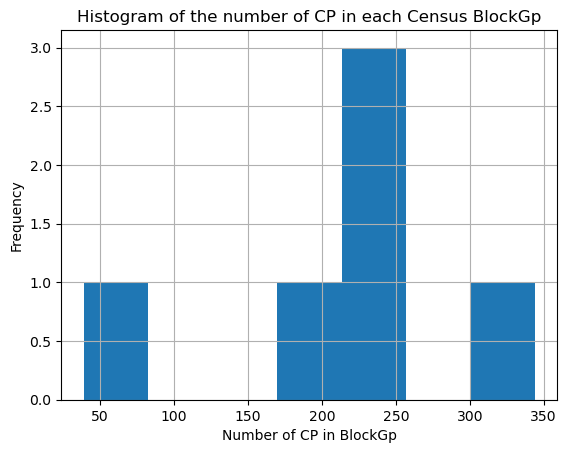

In [26]:
# Consolidate the many CP units into blockgroups  Rember the Omit < is set at 10 
UnitCol = 'BlockGp_ID'
BlockGp_priority_frame_base = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=10)
BlockGp_priority_frame_base['OSDS_count'].hist(bins=len(BlockGp_priority_frame_base['OSDS_count'].unique())+1)   # adding a +1 because the histogram looked weird with only 2 blkgrps in the frame
plt.title("Histogram of the number of CP in each Census BlockGp"); plt.xlabel("Number of CP in BlockGp"); plt.ylabel("Frequency")

In [27]:
# Cut columns to desired ones 
WantCols = ['BlockGp_ID', 'Final_Prioity_Score','Soil_Suitability_Rank', 'SLR_Rank', 'WELLCZ_Rank',
       'dist2_coast_m_Rank', 'dist2_Strm_Wtlnd_m_Rank', 'rainfall_in_Rank',
       'dist2_MunWells_m_Rank', 'dist2_DomWells_m_Rank', 'Dep_to_Water_m_Rank',
       'OSDS_Density_perAcre_Rank', 'Swim_beach_Rank', 'UserDays_Rank', "Fish_Rank", "Coral_Rank", 'Wave_pwr_Rank',
       'OSDS_count']   # will delete OSDS count once is in name col   #  'PepPerHos_Rank',
 
compare_priority_score_BlockGp = BlockGp_priority_frame_base[WantCols]
compare_priority_score_BlockGp = compare_priority_score_BlockGp.sort_values("Final_Prioity_Score", ascending=False)



# Add on the # of CPs to the index 
compare_priority_score_BlockGp['BlockGp_ID'] = compare_priority_score_BlockGp['BlockGp_ID'].astype(str)+": CPs="+compare_priority_score_BlockGp['OSDS_count'].astype(str)
compare_priority_score_BlockGp = compare_priority_score_BlockGp.set_index('BlockGp_ID')                                  # Convert to pandas bliss
del compare_priority_score_BlockGp['OSDS_count']

# make 
renamas = {'Final_Prioity_Score':'Final Prioity Score', 
            'Soil_Suitability_Rank':'Soil Suitability',
            'SLR_Rank':'Sea Level Rise',
            'WELLCZ_Rank':'Well Capture Zones',
            'dist2_coast_m_Rank':'Dist. to Coast',
            'dist2_Strm_Wtlnd_m_Rank':'Dist. to Strms/Wtlnds',
            'rainfall_in_Rank':'Rainfall',
            'dist2_MunWells_m_Rank':'Dist. to Muni. Wells',
            'dist2_DomWells_m_Rank':'Dist. to Dom. Wells',
            'Dep_to_Water_m_Rank':'Depth to GW',
            'OSDS_Density_perAcre_Rank':'OSDS Density',
            'Swim_beach_Rank':'Swim Beaches',
            'UserDays_Rank':'Coastline Usage',
            'Fish_Rank':'Reef Fishery Priority',
            'Coral_Rank':'Coral Reef Priority', 
            'Wave_pwr_Rank': 'Wave Power'}    # , 'PepPerHos_Rank':'People per House'}

compare_priority_score_BlockGp.rename(columns=renamas, inplace=True)     # Rename to col that you want

In [50]:
compare_priority_score_BlockGp

,Final Prioity Score,Soil Suitability,Sea Level Rise,Well Capture Zones,Dist. to Coast,Dist. to Strms/Wtlnds,Rainfall,Dist. to Muni. Wells,Dist. to Dom. Wells,Depth to GW,OSDS Density,Swim Beaches,Coastline Usage,Reef Fishery Priority,Coral Reef Priority,Wave Power
BlockGp_ID,,,,,,,,,,,,,,,,
788: CPs=39,123.263671,75.186923,104.076923,0.000000,180.207885,191.865861,139.769407,37.892152,49.057909,310.278739,155.368505,0.000000,8.652886,300.000000,99.000000,197.597871
789: CPs=191,104.524842,61.661501,7.774869,0.000000,84.020756,35.954906,132.222715,44.954809,57.093728,123.909482,333.838723,0.000000,4.896674,300.000000,190.743455,190.801014
845: CPs=254,97.427829,64.284016,32.362205,4.133858,133.408320,65.877227,131.589693,101.993887,95.254672,165.640712,98.286221,11.023622,3.228268,235.594488,146.610236,172.130006
787: CPs=236,95.032254,63.734111,27.343220,0.000000,139.727788,92.924675,55.710087,114.617263,180.588594,193.726610,50.640869,7.627119,5.076280,186.483051,146.313559,165.571457
779: CPs=216,65.063752,40.889982,6.472222,0.000000,39.071204,66.222196,86.899255,26.406635,16.397989,82.033416,86.197543,75.925926,19.634070,205.597222,197.736111,26.472506
829: CPs=344,53.217435,55.733371,0.000000,13.953488,15.875152,68.635651,54.507363,85.477133,24.624971,11.652076,112.105767,0.000000,0.606370,160.691860,145.334302,49.064015


The island of Molokai contains 1280 cesspools and has a total of 6 census tracts although only 6 tracts contained more than 25 cesspools and were thus categorized with the HCPT. Of these tracts 33% or 2 of them were categorized as high (1) priority (classified as the top 25% of census tracts statewide), 17% or 1 of them were categorized as medium (2) priority and 50% or 3 of them were categorized as low (3) priority. The total number of cesspools on Molokai catergorized as high (1) priority was 230, with 254 and 796 as medium (2) and low (3) priority, respectivly.


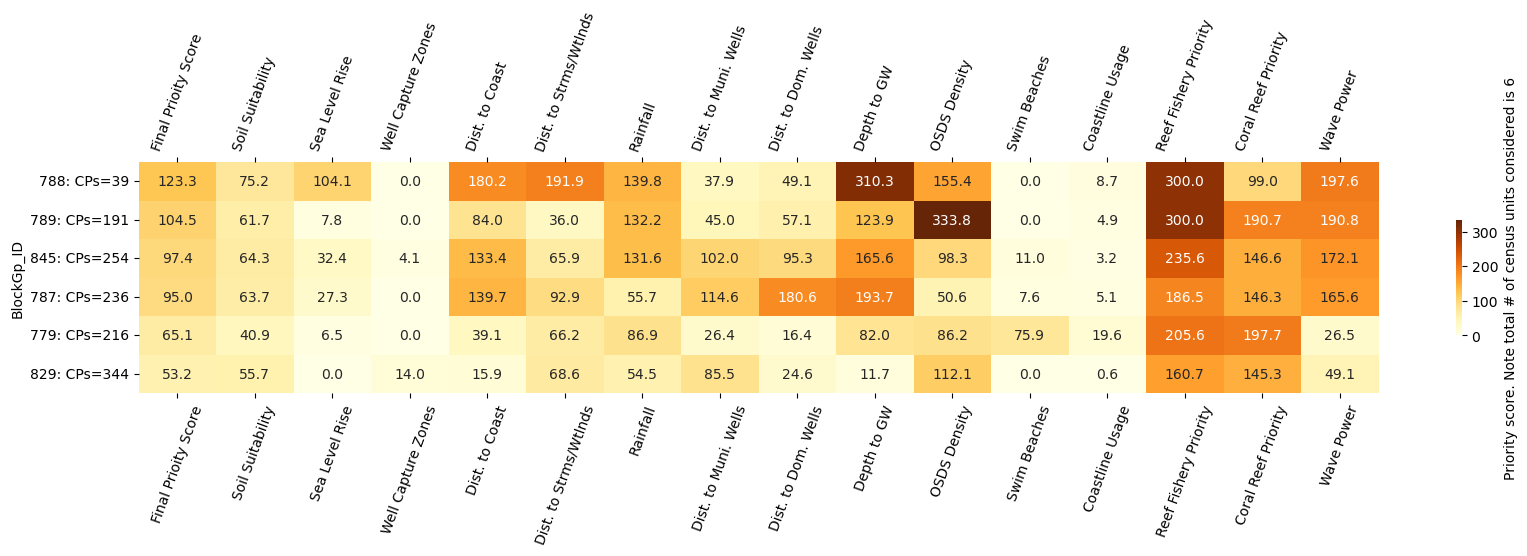

In [53]:
# Plot out comparison heatmap 

Total_census_BlockGps = len(BLOCKGROUP_ID['BlockGp_ID'].unique())

fig, ax = plt.subplots(figsize=(20, 3))
total_num = len(compare_priority_score_BlockGp)
#plt.title("Ranks for all {} census Tracks".format(total_num), fontsize=18, y=1.05)
plt.tick_params(axis='x', which='major', labelsize=10, labelbottom = True, bottom=True, top = True, labeltop=True)
plt.xticks(rotation=70)
bar_label = "Priority score. Note total # of census units considered is {}".format(len(BlockGp_priority_frame_base['OSDS_count']))
g= sns.heatmap(compare_priority_score_BlockGp, annot=True,  cmap = 'YlOrBr', fmt=".1f", cbar_kws={'label': bar_label, "shrink": 0.5})
plt.savefig(os.path.join(".", "Outputs/Figures", "BlockGp_Master_scores_chart.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(".", "Outputs/Figures", "BlockGp_Master_scores_chart.png"), bbox_inches='tight')

print_info_for_islands("Molokai", BlockGp_priority_frame_base, Total_census_BlockGps)

In [55]:
## Final rankings for block groups 
OSDS_Sum_Piv = pd.pivot_table(BlockGp_priority_frame_base, index='Final_Cat_Ranking', aggfunc = 'sum')
OSDS_Sum_Piv['OSDS_pct_in_rank'] = OSDS_Sum_Piv['OSDS_count']/len(OSDS)*100
OSDS_Sum_Piv[['OSDS_count', 'OSDS_pct_in_rank']]

,OSDS_count,OSDS_pct_in_rank
Final_Cat_Ranking,,
High,230,17.96875
Low,796,62.18750
Medium,254,19.84375


## Consolidation by blocks
Molokai is small and only has 2 tracts.... 

Text(0, 0.5, 'Frequency')

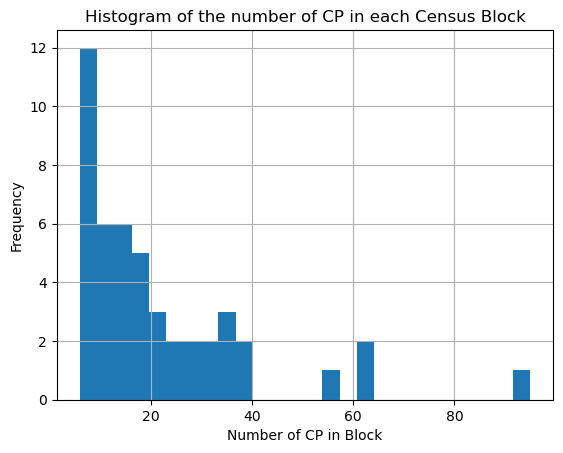

In [56]:
# Consolidate the many CP units into blockgroups  Rember the Omit < is set at 5 
UnitCol = 'BlockBk_ID'
Block_priority_frame_base = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol, omit_less_than=5)
Block_priority_frame_base['OSDS_count'].hist(bins=len(Block_priority_frame_base['OSDS_count'].unique()))   # adding a +1 because the histogram looked weird with only 2 blkgrps in the frame
plt.title("Histogram of the number of CP in each Census Block"); plt.xlabel("Number of CP in Block"); plt.ylabel("Frequency")

In [57]:
# Cut columns to desired ones 
WantCols = ['BlockBk_ID', 'Final_Prioity_Score','Soil_Suitability_Rank', 'SLR_Rank', 'WELLCZ_Rank',
       'dist2_coast_m_Rank', 'dist2_Strm_Wtlnd_m_Rank', 'rainfall_in_Rank',
       'dist2_MunWells_m_Rank', 'dist2_DomWells_m_Rank', 'Dep_to_Water_m_Rank',
       'OSDS_Density_perAcre_Rank', 'Swim_beach_Rank', 'UserDays_Rank', "Fish_Rank", "Coral_Rank", 'Wave_pwr_Rank',
       'OSDS_count']   # will delete OSDS count once is in name col   #  'PepPerHos_Rank',
 
compare_priority_score_Block = Block_priority_frame_base[WantCols]
compare_priority_score_Block = compare_priority_score_Block.sort_values("Final_Prioity_Score", ascending=False)



# Add on the # of CPs to the index 
compare_priority_score_Block['BlockBk_ID'] = compare_priority_score_Block['BlockBk_ID'].astype(str)+": CPs="+compare_priority_score_Block['OSDS_count'].astype(str)
compare_priority_score_Block = compare_priority_score_Block.set_index('BlockBk_ID')                                  # Convert to pandas bliss
del compare_priority_score_Block['OSDS_count']

# make 
renamas = {'Final_Prioity_Score':'Final Prioity Score', 
            'Soil_Suitability_Rank':'Soil Suitability',
            'SLR_Rank':'Sea Level Rise',
            'WELLCZ_Rank':'Well Capture Zones',
            'dist2_coast_m_Rank':'Dist. to Coast',
            'dist2_Strm_Wtlnd_m_Rank':'Dist. to Strms/Wtlnds',
            'rainfall_in_Rank':'Rainfall',
            'dist2_MunWells_m_Rank':'Dist. to Muni. Wells',
            'dist2_DomWells_m_Rank':'Dist. to Dom. Wells',
            'Dep_to_Water_m_Rank':'Depth to GW',
            'OSDS_Density_perAcre_Rank':'OSDS Density',
            'Swim_beach_Rank':'Swim Beaches',
            'UserDays_Rank':'Coastline Usage',
            'Fish_Rank':'Reef Fishery Priority',
            'Coral_Rank':'Coral Reef Priority', 
            'Wave_pwr_Rank': 'Wave Power'}    # , 'PepPerHos_Rank':'People per House'}

compare_priority_score_Block.rename(columns=renamas, inplace=True)     # Rename to col that you want

In [58]:
compare_priority_score_Block

,Final Prioity Score,Soil Suitability,Sea Level Rise,Well Capture Zones,Dist. to Coast,Dist. to Strms/Wtlnds,Rainfall,Dist. to Muni. Wells,Dist. to Dom. Wells,Depth to GW,OSDS Density,Swim Beaches,Coastline Usage,Reef Fishery Priority,Coral Reef Priority,Wave Power
BlockBk_ID,,,,,,,,,,,,,,,,
21768: CPs=16,129.405838,77.443333,123.750000,0.00,233.228798,209.479329,140.685156,37.691510,48.776033,312.500985,151.743743,0.0,9.190809,300.000000,99.00,197.597871
20013: CPs=14,122.220157,66.985476,28.285714,0.00,147.384234,62.940284,51.562637,288.811183,274.367188,247.395881,89.624899,0.0,0.199800,285.428571,99.00,200.000000
20335: CPs=18,121.769088,78.237778,27.500000,0.00,204.692145,21.137711,141.059602,45.331054,57.534870,265.308103,287.939377,0.0,2.197802,300.000000,198.00,197.597871
21181: CPs=23,118.990859,73.617246,90.391304,0.00,143.323772,179.613013,139.132364,38.031729,49.253996,308.732828,157.890079,0.0,8.278678,300.000000,99.00,197.597871
21424: CPs=8,118.864590,59.939583,0.000000,56.25,62.134800,141.510118,135.904013,332.477762,304.273319,112.340289,17.983780,0.0,1.698302,173.625000,236.25,148.581889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21213: CPs=9,44.083307,55.106778,0.000000,0.00,18.602800,94.831704,62.124971,42.878569,21.236129,14.677956,27.080058,0.0,0.199800,198.000000,110.00,16.510836
21211: CPs=8,43.284757,31.222000,0.000000,0.00,10.707350,18.359254,81.318660,27.658526,18.390850,19.477596,29.615081,0.0,0.199800,198.000000,198.00,16.322235
21894: CPs=6,42.372058,53.332000,0.000000,0.00,13.075803,37.942533,59.994222,51.760737,22.639728,13.757026,67.640430,0.0,1.864802,198.000000,99.00,16.573595


The island of Molokai contains 1036 cesspools and has a total of 156 census tracts although only 47 tracts contained more than 25 cesspools and were thus categorized with the HCPT. Of these tracts 26% or 12 of them were categorized as high (1) priority (classified as the top 25% of census tracts statewide), 26% or 12 of them were categorized as medium (2) priority and 49% or 23 of them were categorized as low (3) priority. The total number of cesspools on Molokai catergorized as high (1) priority was 238, with 348 and 450 as medium (2) and low (3) priority, respectivly.


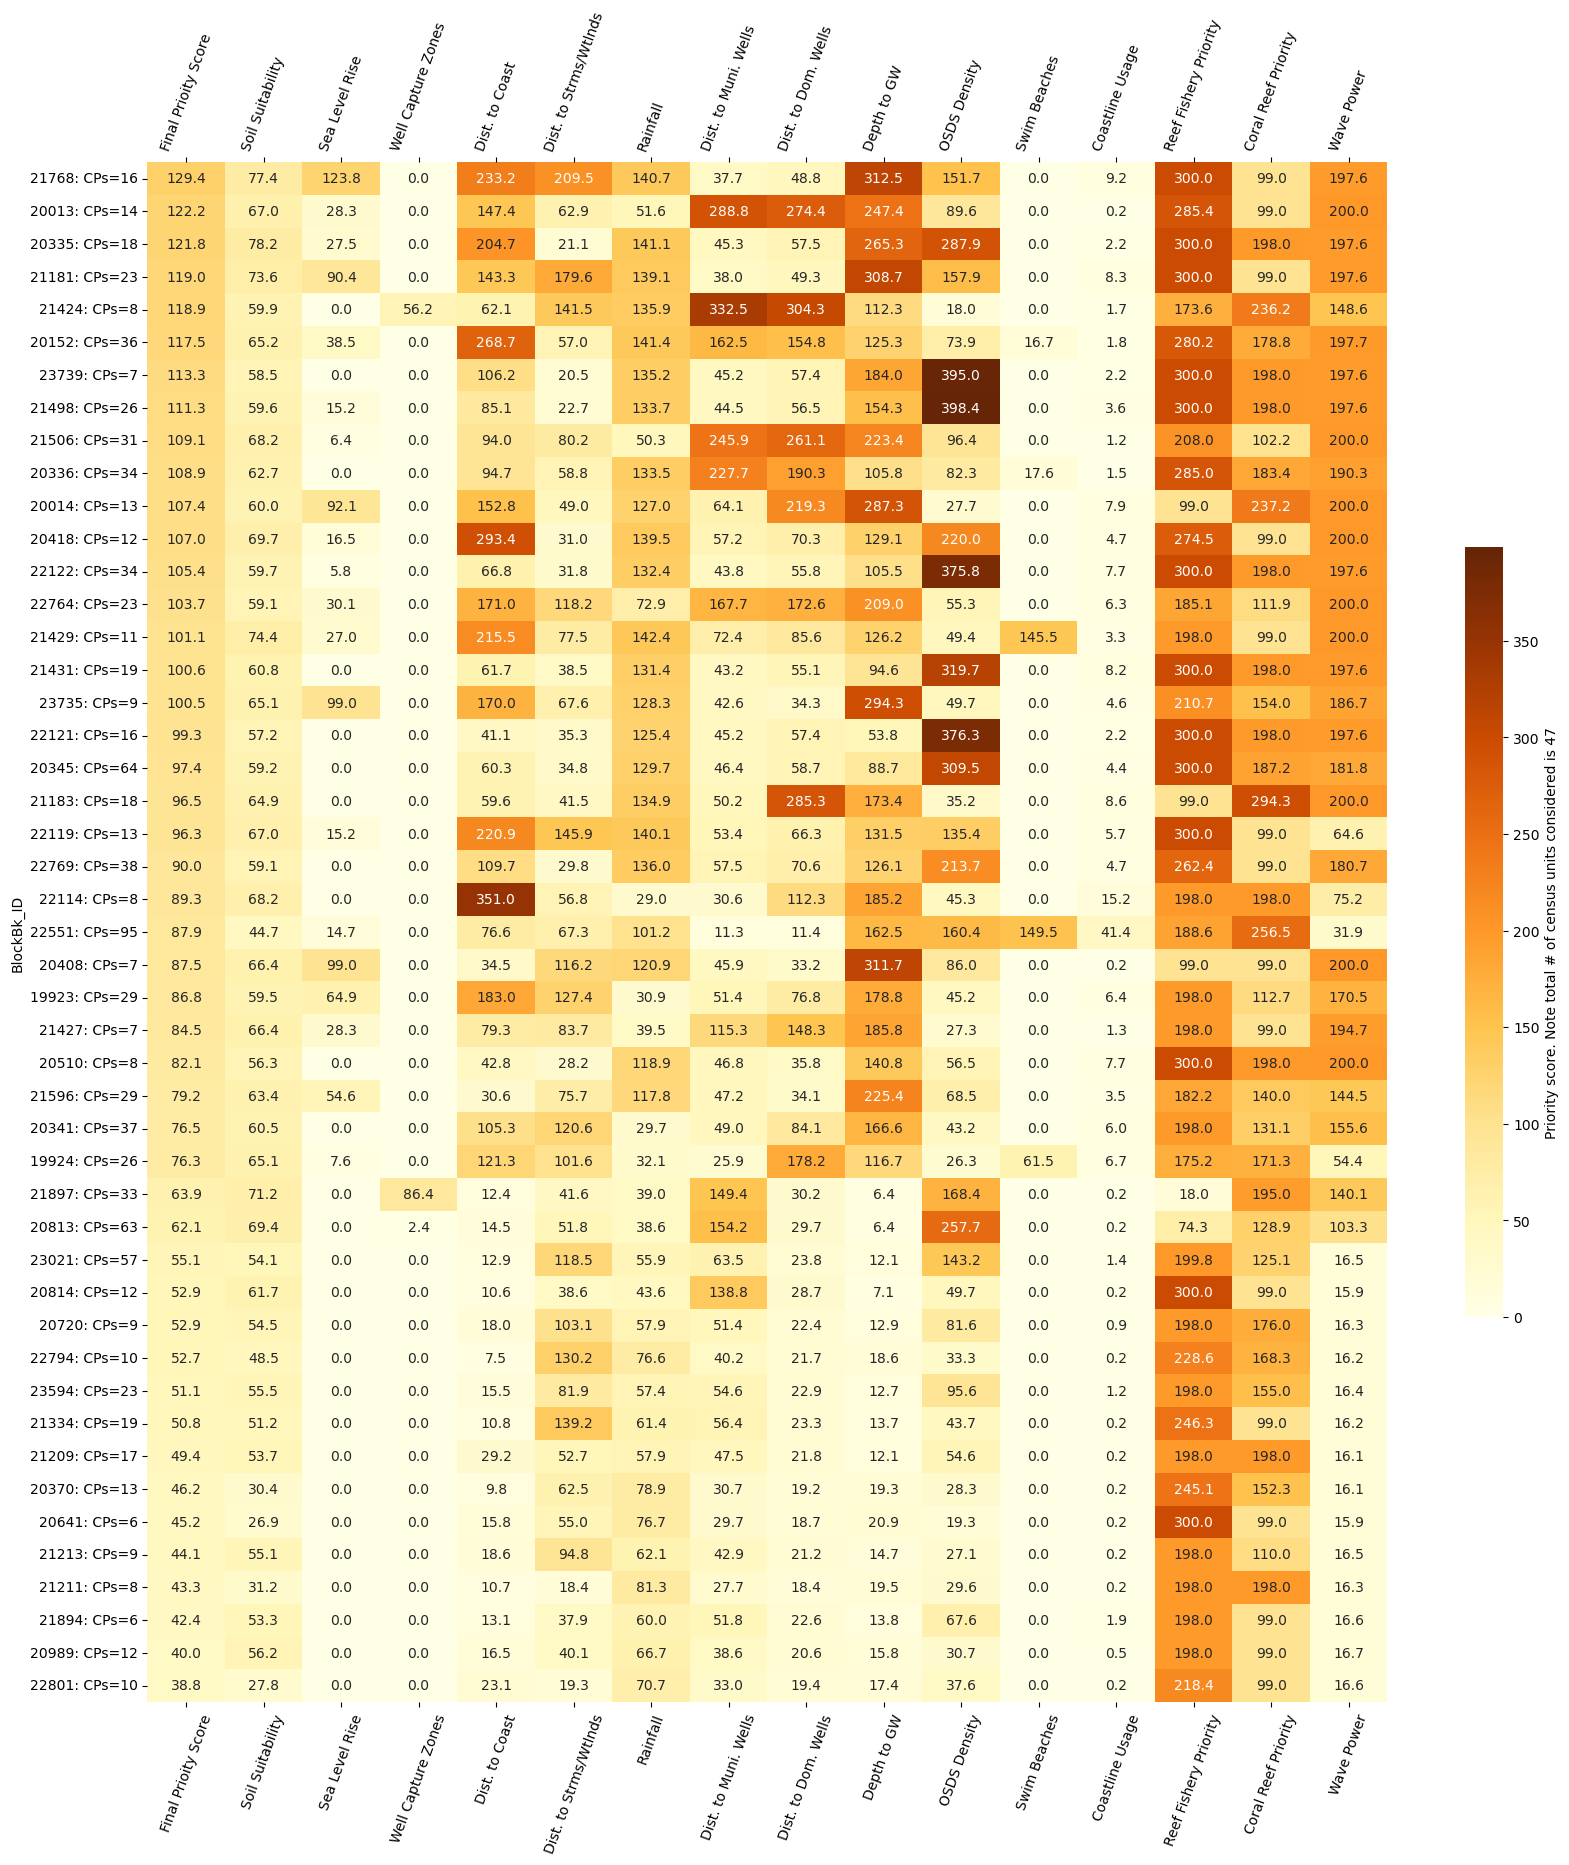

In [59]:
# Plot out comparison heatmap 

Total_census_Blocks = len(BLOCK_ID['BlockBk_ID'].unique())

fig, ax = plt.subplots(figsize=(20, 20))
total_num = len(compare_priority_score_Block)
#plt.title("Ranks for all {} census Tracks".format(total_num), fontsize=18, y=1.05)
plt.tick_params(axis='x', which='major', labelsize=10, labelbottom = True, bottom=True, top = True, labeltop=True)
plt.xticks(rotation=70)
bar_label = "Priority score. Note total # of census units considered is {}".format(len(Block_priority_frame_base['OSDS_count']))
g= sns.heatmap(compare_priority_score_Block, annot=True,  cmap = 'YlOrBr', fmt=".1f", cbar_kws={'label': bar_label, "shrink": 0.5})
plt.savefig(os.path.join(".", "Outputs/Figures", "Block_Master_scores_chart.pdf"), bbox_inches='tight')
plt.savefig(os.path.join(".", "Outputs/Figures", "Block_Master_scores_chart.png"), bbox_inches='tight')

print_info_for_islands("Molokai", Block_priority_frame_base, Total_census_Blocks)

In [66]:
## Final rankings for blocks 
OSDS_Sum_Piv = pd.pivot_table(Block_priority_frame_base, index='Final_Cat_Ranking', aggfunc = 'sum')
OSDS_Sum_Piv['OSDS_pct_in_rank'] = OSDS_Sum_Piv['OSDS_count']/len(OSDS)*100
OSDS_Sum_Piv[['OSDS_count', 'OSDS_pct_in_rank']]

,OSDS_count,OSDS_pct_in_rank
Final_Cat_Ranking,,
High,238,18.59375
Low,450,35.15625
Medium,348,27.18750


## Save Census Area Shapefiles
!! SUPER LONG RUNTIMES ON CELLS BELOW !!

### Print Shapefile, summarized by census Tracts 


In [58]:
# For tracks 
UnitCol=['Track_ID']
# Cols for all of the below
OutCols = ['Final_Prioity_Score', 'OSDS_count']  #  'PepPerHos', # 'Final_Prioity_Rank', 
all_cols = UnitCol + OutCols + Rank_Cols +[ 'Final_Cat_Ranking', 'Fin_Rank',]   # 'Final_Cat_Ranking'  comment out rank cols to just print simple shapefile  # 'In_2017_CP_zone',
clean_cols = UnitCol + OutCols +['Final_Cat_Ranking', 'Fin_Rank']   #     'In_2017_CP_zone',

# Group up the OSDS units into census areas 
Tracks_priority_frame = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol[0], omit_less_than=25)
Tracks_priority_frame =   Tracks_priority_frame.merge(Track_meta, on='Track_ID', how='left')  # Add in the name ID from the Track_meta in above cell
Tracks_priority_frame['Name_ID'] = Tracks_priority_frame['Name_ID']+": CPs="+Tracks_priority_frame['OSDS_count'].astype(str)
Tracks_priority_frame.set_index("Name_ID", drop=True, inplace=True)

# Save Full Shapefile 
Pivot_df = Tracks_priority_frame[all_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_census_tracts_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Tracts_Full.shp')  
make_census_unit_SHP(Pivot_df, all_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Tracts_Full.csv'))

# Save clean Shapefile 
Pivot_df = Tracks_priority_frame[clean_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_census_tracts_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Tracts_Clean.shp')  
make_census_unit_SHP(Pivot_df, clean_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Tracts_Clean.csv'))

### Print Shapefile, summarized by census Block_Groups 

In [59]:
UnitCol=['BlockGp_ID']
# Cols for all of the below
OutCols = ['Final_Prioity_Score', 'OSDS_count']  #  'PepPerHos', # 'Final_Prioity_Rank', 
all_cols = UnitCol + OutCols + Rank_Cols +[ 'Final_Cat_Ranking', 'Fin_Rank',]   # 'Final_Cat_Ranking'  comment out rank cols to just print simple shapefile  # 'In_2017_CP_zone',
clean_cols = UnitCol + OutCols +['Final_Cat_Ranking', 'Fin_Rank']   #  'In_2017_CP_zone',

Block_groups_priority_frame = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol[0], omit_less_than=10)
# get the name metadata from other metadata files
Block_groups_meta = get_blkGrp_names(os.path.join("..", "Projected_data/Census/With_2017_priority", '2010_Census_Block_Groups_Meta_w2017.shp'), 'BlockGp_ID')
Block_groups_priority_frame =   Block_groups_priority_frame.merge(Block_groups_meta, on=UnitCol, how='left')  # Add in the name ID from the Track_meta in above cell
Block_groups_priority_frame['Name_ID'] = Block_groups_priority_frame['Name_ID']+": CPs="+Block_groups_priority_frame['OSDS_count'].astype(str)
Block_groups_priority_frame.set_index("Name_ID", drop=True, inplace=True)

# Save Full Shapefile 
Pivot_df = Block_groups_priority_frame[all_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Block_Groups_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_BlockGrps_Full.shp') 
make_census_unit_SHP(Pivot_df, all_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_BlockGrps_Full.csv'))

# Save clean Shapefile 
Pivot_df = Block_groups_priority_frame[clean_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Block_Groups_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_BlockGrps_Clean.shp') 
make_census_unit_SHP(Pivot_df, clean_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_BlockGrps_Clean.csv'))

### Print Shapefile, summarized by census Blocks

In [60]:
UnitCol=['BlockBk_ID']
# Cols for all of the below
OutCols = ['Final_Prioity_Score', 'OSDS_count']  #  'PepPerHos', # 'Final_Prioity_Rank', 
all_cols = UnitCol + OutCols + Rank_Cols +['Final_Cat_Ranking', 'Fin_Rank',]   # 'Final_Cat_Ranking'  comment out rank cols to just print simple shapefile 'In_2017_CP_zone',
clean_cols = UnitCol + OutCols +['Final_Cat_Ranking', 'Fin_Rank']   #  'In_2017_CP_zone',

Blocks_priority_frame = group_by_census_unit(BASE_PRIORITY_MASTER, UnitCol[0], omit_less_than=5)

# Save full shapefile 
Pivot_df = Blocks_priority_frame[all_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Blocks_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Blocks_Full.shp') 
make_census_unit_SHP(Pivot_df, all_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Blocks_Full.csv'))

# Save clean Shapefile 
Pivot_df = Blocks_priority_frame[clean_cols]
in_polygon_blocktrack = os.path.join("..", "Projected_data/Census", '2010_Census_Blocks_Clean.shp')
OutShpPath = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Blocks_Clean.shp') 
make_census_unit_SHP(Pivot_df, clean_cols, OutShpPath, in_polygon_blocktrack)
Pivot_df.to_csv(os.path.join(".", "Outputs/Census_aggregared_CSVs", 'Final_Priority_Blocks_Clean.csv'))

### Print final priority OSDS master  (cesspool dots) 


In [61]:
# Save the final priority CP dots
BASE_PRIORITY_MASTER.to_csv(os.path.join(os.path.abspath("Outputs/OSDS_Dots"), "Final_Priority_Master_CP.csv"))


# Convert CSV to a POINTS shapefile of the OSDS points 
XFieldName = 'X'                                 # THe x field longitude 
YFieldName = 'Y'                                 # THe y field latitude 
spatialRef = arcpy.SpatialReference(4326)        # THis is wgs84
csvFilePath = os.path.join(os.path.abspath("Outputs/OSDS_Dots"), "Final_Priority_Master_CP.csv")
shpFilePath = os.path.abspath("Outputs/OSDS_Dots")

arcpy.MakeXYEventLayer_management(csvFilePath, XFieldName, YFieldName, 'Final_Priority_Master_CP', spatial_reference=spatialRef)
arcpy.FeatureClassToShapefile_conversion('Final_Priority_Master_CP', shpFilePath)    # Shapefile name will be "{}.shp".format(var)

# And print the raw riskfactors as a shapefile too
csvFilePath = os.path.join(os.path.abspath("Outputs/OSDS_Dots"), "Final_Priority_Master_CP.csv")
shpFilePath = os.path.abspath("Outputs/OSDS_Dots")


arcpy.MakeXYEventLayer_management(csvFilePath, XFieldName, YFieldName, 'OSDS_MASTER_RiskFactors_v6', spatial_reference=spatialRef)
arcpy.FeatureClassToShapefile_conversion('OSDS_MASTER_RiskFactors_v6', shpFilePath)    # Shapefile name will be "{}.shp".format(var)



<Result 'c:\\Users\\CS\\Desktop\\git_repos\\hcpt_molokai\\Scripts\\Outputs\\OSDS_Dots'>

### Print out OSDS dots shapefiles with census areas attributes 


In [62]:
# create OSDS dots file with the synthesized TRACT area attributes 
In_polygons = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Tracts_Clean.shp')  
In_points = osds_path

arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(".", "Outputs/OSDS_Dots", "OSDS_dots_w_Tracts_Clean_atts.shp"))


# create OSDS dots file with the synthesized BLOCKGroups area attributes 
In_polygons = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_BlockGrps_Clean.shp')  
In_points = osds_path

arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(".", "Outputs/OSDS_Dots", "OSDS_dots_w_BlkGrps_Clean_atts.shp"))

# create OSDS dots file with the synthesized BLOCKGroups area attributes 
In_polygons = os.path.join(".", "Outputs", "Census_aggregared_SHPs", 'Final_Priority_Blocks_Clean.shp')  
In_points = osds_path

arcpy.SpatialJoin_analysis(In_points, In_polygons, os.path.join(".", "Outputs/OSDS_Dots", "OSDS_dots_w_Blocks_Clean_atts.shp"))

<Result '.\\Outputs\\OSDS_Dots\\OSDS_dots_w_Blocks_Clean_atts.shp'>

## QAQC on each dataset

In [63]:
for i in mergeframes_list:
    print("{}".format(i.columns[-1]))
    print("Number of points                   = {}".format(len(i)))
    print("Number of Uid that are null        = {}".format(len(i[i["Uid"].isnull()])))
    print("Number of Uid that are zero        = {}".format(len(i[i["Uid"] == 0])))
    print("Number of {} values that are null  = {}".format(i.columns[-1], len(i[i[i.columns[-1]].isnull()])))
    print("Number of {} values that are zero  = {}".format(i.columns[-1], len(i[i[i.columns[-1]] == 0])))
    print('\n')        

BlockBk_ID
Number of points                   = 1280
Number of Uid that are null        = 0
Number of Uid that are zero        = 0
Number of BlockBk_ID values that are null  = 0
Number of BlockBk_ID values that are zero  = 0


BlockGp_ID
Number of points                   = 1280
Number of Uid that are null        = 0
Number of Uid that are zero        = 0
Number of BlockGp_ID values that are null  = 0
Number of BlockGp_ID values that are zero  = 0


Track_ID
Number of points                   = 1280
Number of Uid that are null        = 0
Number of Uid that are zero        = 0
Number of Track_ID values that are null  = 0
Number of Track_ID values that are zero  = 0


Flikr_Y
Number of points                   = 1280
Number of Uid that are null        = 0
Number of Uid that are zero        = 0
Number of Flikr_Y values that are null  = 0
Number of Flikr_Y values that are zero  = 335


UserDays
Number of points                   = 1280
Number of Uid that are null        = 0
Number of Uid t

## DELETE  large files >100mb from offsite repo 
- Some of the files this notebook depends on are too large to be hosted by GitHub
- One solution is to place these files into a cloud-based repositiry, in this case I use Digital Ocean spaces, and then just download them at the beginning of the work session
- Once the analysis is complete USE THIS CELL to remove these files from the Github Repo so any updates dont include the large files 

In [64]:
## Get rid of the Lidar files 
#delete_downloaded_files(LIDAR_file_urls, LIDAR_local_folder)